# Assignment 2: Stochastic and Spatial Models

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from scipy import stats

%matplotlib inline
plt.style.use('default')

## Stochastic Models

### Implement Gillispie's algorithm & Investigate Simulation Variability and Negative Co-variance

In [2]:
# Function to run a single Gillespie simulation
def gillespie_SIR(beta, gamma, N, S0, I0, R0, t_max):
    '''
    This function exectutes Gillespie's algorithm. 
    Args:
        beta: 
        gamma:
        N: 
        S0: 
        I0: 
        
    '''
    S = S0
    I = I0
    R = R0
    t = 0

    times = [t]
    S_vals = [S]
    I_vals = [I]
    R_vals = [R]

    while t < t_max and I > 0:
        # Calculate rates
        a1 = beta * S * I / N     # Infection rate
        a2 = gamma * I            # Recovery rate
        a0 = a1 + a2              # Total rate

        if a0 == 0:
            break

        # Time to next event
        r1 = np.random.uniform()
        delta_t = -np.log(r1) / a0
        t += delta_t

        # Determine event
        r2 = np.random.uniform()
        if r2 < a1 / a0:
            # Infection event
            S -= 1
            I += 1
        else:
            # Recovery event
            I -= 1
            R += 1

        # Store results
        times.append(t)
        S_vals.append(S)
        I_vals.append(I)
        R_vals.append(R)

    return np.array(times), np.array(S_vals), np.array(I_vals), np.array(R_vals)

# Function for deterministic SIR model
def SIR_ode(y, t, beta, gamma, N):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

In [3]:
# Parameters
beta = 0.3      # Transmission rate
gamma = 0.1     # Recovery rate
N = 1000        # Total population
num_simulations = 100  # Number of stochastic simulations
t_max = 160     # Maximum time

# Time points for deterministic solution
t_det = np.linspace(0, t_max, 1000)

# Initial conditions
S0 = N - 1
I0 = 1
R0 = 0

# Solve deterministic SIR model
y0 = [S0, I0, R0]
ret = odeint(SIR_ode, y0, t_det, args=(beta, gamma, N))
S_det, I_det, R_det = ret.T

# Lists to store multiple simulation results
S_values = []
I_values = []
R_values = []
time_values = []

# Run multiple Gillespie simulations
for sim in range(num_simulations):
    times, S_vals, I_vals, R_vals = gillespie_SIR(beta, gamma, N, S0, I0, R0, t_max)
    I_values.append(I_vals)
    S_values.append(S_vals)
    R_values.append(R_vals)
    time_values.append(times)

# Align data for statistical analysis
max_len = max(len(tv) for tv in time_values)
time_grid = np.linspace(0, t_max, max_len)

I_interp = np.zeros((num_simulations, max_len))
S_interp = np.zeros((num_simulations, max_len))
R_interp = np.zeros((num_simulations, max_len))

for i in range(num_simulations):
    I_interp[i, :] = np.interp(time_grid, time_values[i], I_values[i])
    S_interp[i, :] = np.interp(time_grid, time_values[i], S_values[i])
    R_interp[i, :] = np.interp(time_grid, time_values[i], R_values[i])

# Compute statistics
I_mean = np.mean(I_interp, axis=0)
I_var = np.var(I_interp, axis=0)
S_mean = np.mean(S_interp, axis=0)
S_var = np.var(S_interp, axis=0)
cov_SI = np.mean((S_interp - S_mean) * (I_interp - I_mean), axis=0)


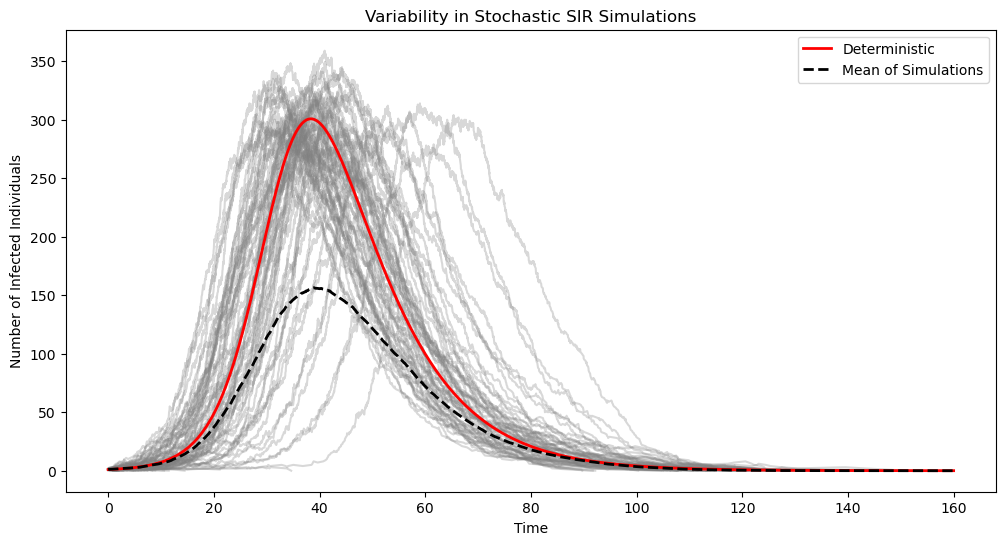

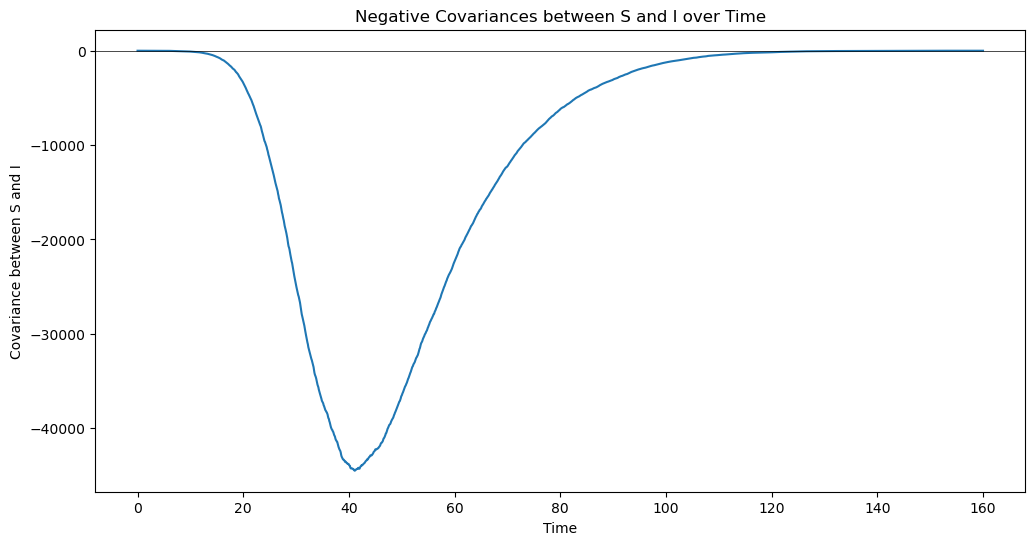

In [4]:
# Plotting results

# 1. Variability: Plot multiple stochastic simulations and compare with deterministic solution
plt.figure(figsize=(12, 6))
for i in range(num_simulations):
    plt.plot(time_values[i], I_values[i], color='grey', alpha=0.3)
plt.plot(t_det, I_det, 'r', lw=2, label='Deterministic')
plt.plot(time_grid, I_mean, 'k--', lw=2, label='Mean of Simulations')
plt.xlabel('Time')
plt.ylabel('Number of Infected Individuals')
plt.title('Variability in Stochastic SIR Simulations')
plt.legend()
plt.show()

# 2. Negative Covariances: Plot covariance between S and I over time
plt.figure(figsize=(12, 6))
plt.plot(time_grid, cov_SI)
plt.xlabel('Time')
plt.ylabel('Covariance between S and I')
plt.title('Negative Covariances between S and I over Time')
plt.axhline(0, color='black', lw=0.5)
plt.show()

### Stochastic Resonance and Increased Transients

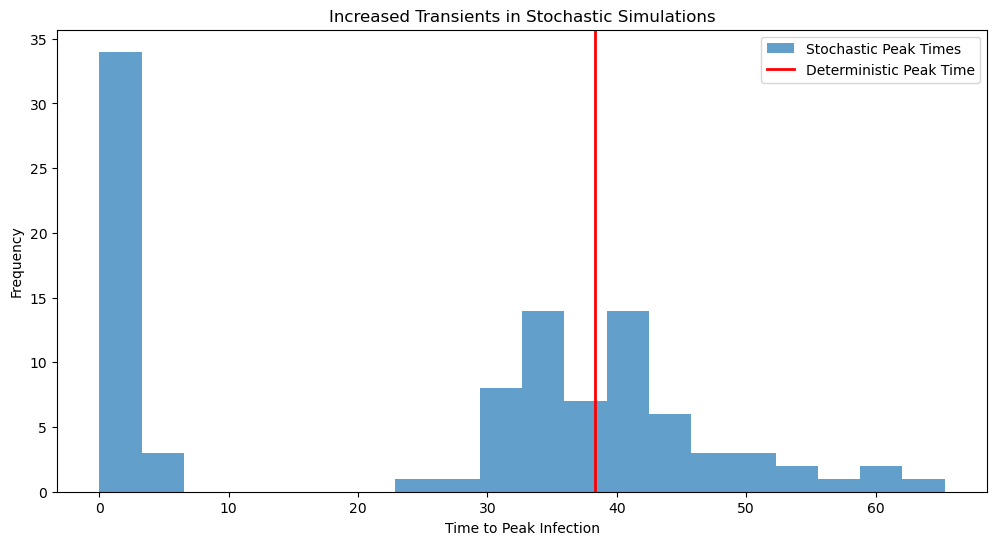

In [5]:
# 3. Increased Transients: Compare the time to reach peak infection
peak_time_det = t_det[np.argmax(I_det)]
peak_times_stoch = [time_values[i][np.argmax(I_values[i])] for i in range(num_simulations)]

plt.figure(figsize=(12, 6))
plt.hist(peak_times_stoch, bins=20, alpha=0.7, label='Stochastic Peak Times')
plt.axvline(peak_time_det, color='red', lw=2, label='Deterministic Peak Time')
plt.xlabel('Time to Peak Infection')
plt.ylabel('Frequency')
plt.title('Increased Transients in Stochastic Simulations')
plt.legend()
plt.show()

### Extinction events and Critical Community Size

In [6]:
# 4. Stochastic Resonance: Introduce periodic forcing in beta
def beta_time(t, beta0, amplitude, frequency):
    return beta0 * (1 + amplitude * np.sin(2 * np.pi * frequency * t))

# Modify the Gillespie function to accept time-dependent beta
def gillespie_SIR_forced(beta_func, gamma, N, S0, I0, R0, t_max):
    S = S0
    I = I0
    R = R0
    t = 0

    times = [t]
    S_vals = [S]
    I_vals = [I]
    R_vals = [R]

    while t < t_max and I > 0:
        current_beta = beta_func(t)
        a1 = current_beta * S * I / N
        a2 = gamma * I
        a0 = a1 + a2

        if a0 == 0:
            break

        r1 = np.random.uniform()
        delta_t = -np.log(r1) / a0
        t += delta_t

        r2 = np.random.uniform()
        if r2 < a1 / a0:
            S -= 1
            I += 1
        else:
            I -= 1
            R += 1

        times.append(t)
        S_vals.append(S)
        I_vals.append(I)
        R_vals.append(R)

    return np.array(times), np.array(S_vals), np.array(I_vals), np.array(R_vals)

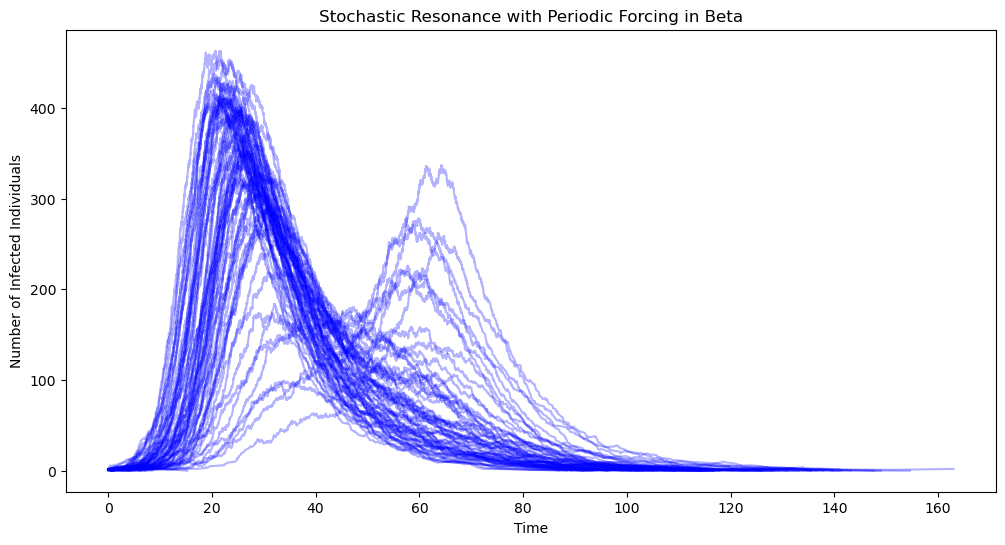

Number of extinctions out of 100 simulations: 100


In [7]:
# Parameters for periodic forcing
amplitude = 0.5
frequency = 1/50  # One oscillation every 50 time units

# Run multiple simulations with periodic forcing
I_values_forced = []
time_values_forced = []

for sim in range(num_simulations):
    times_f, _, I_vals_f, _ = gillespie_SIR_forced(
        lambda t: beta_time(t, beta, amplitude, frequency), gamma, N, S0, I0, R0, t_max)
    I_values_forced.append(I_vals_f)
    time_values_forced.append(times_f)

# Plotting the effect of stochastic resonance
plt.figure(figsize=(12, 6))
for i in range(num_simulations):
    plt.plot(time_values_forced[i], I_values_forced[i], color='blue', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Number of Infected Individuals')
plt.title('Stochastic Resonance with Periodic Forcing in Beta')
plt.show()

# 5. Extinctions: Count the number of simulations where the disease goes extinct
extinctions = sum(1 for I_vals in I_values if I_vals[-1] == 0)
print(f'Number of extinctions out of {num_simulations} simulations: {extinctions}')

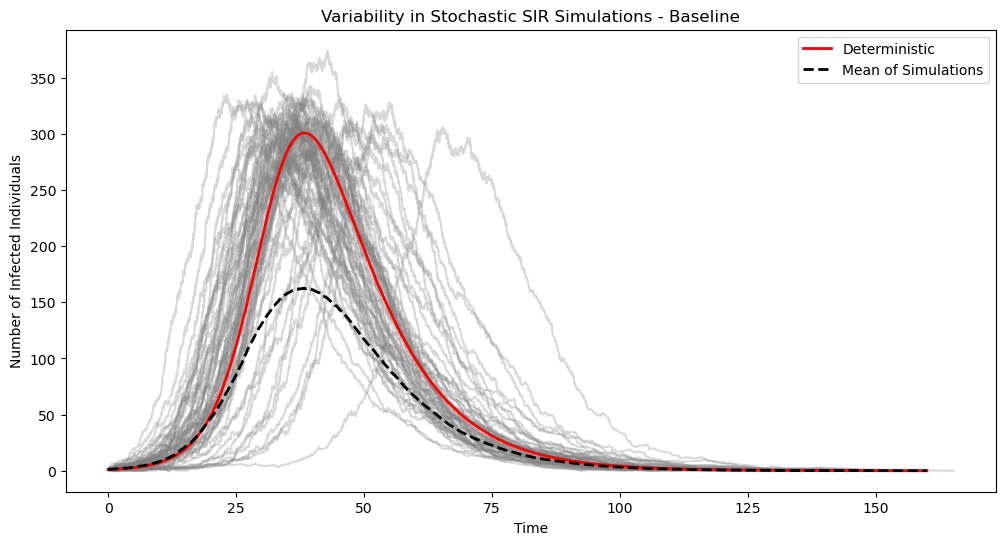

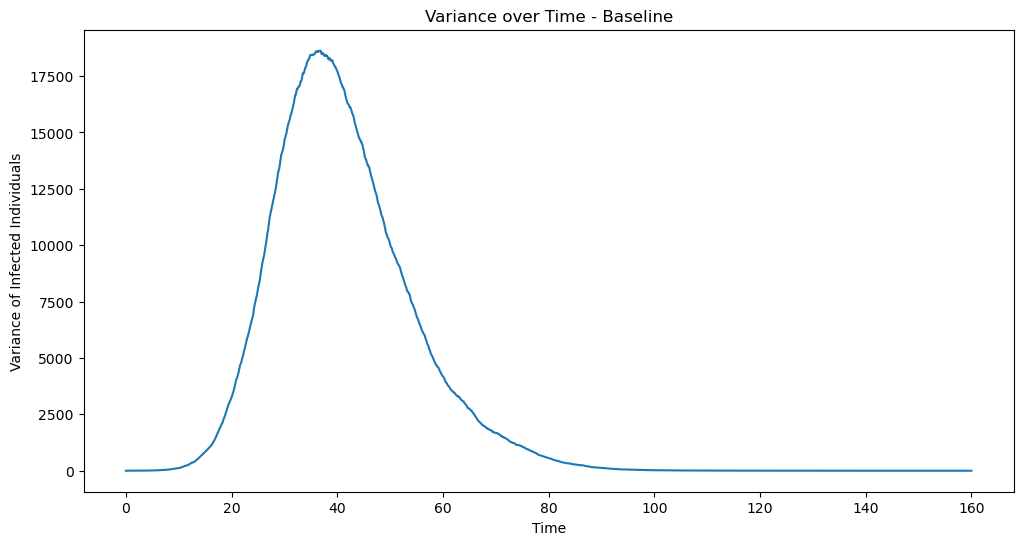

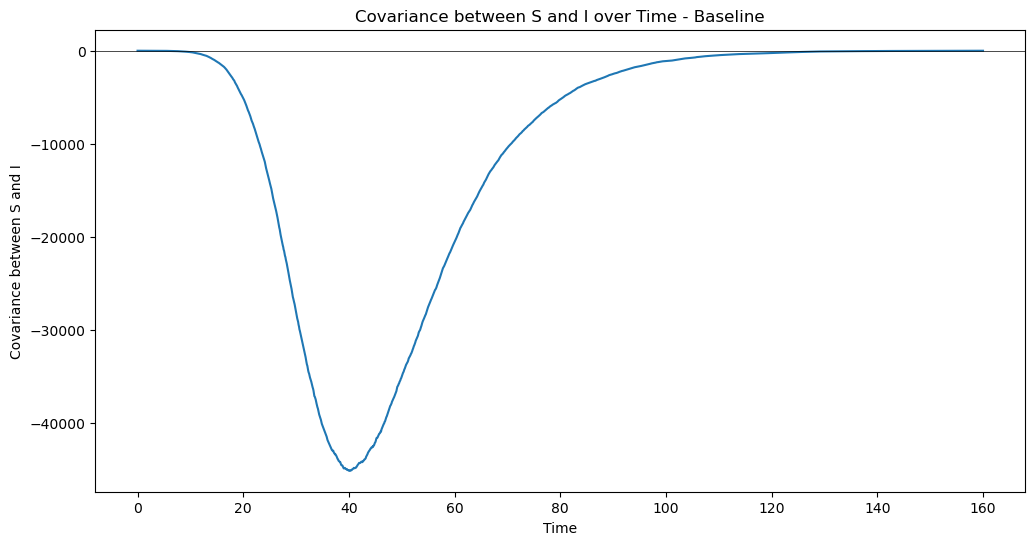

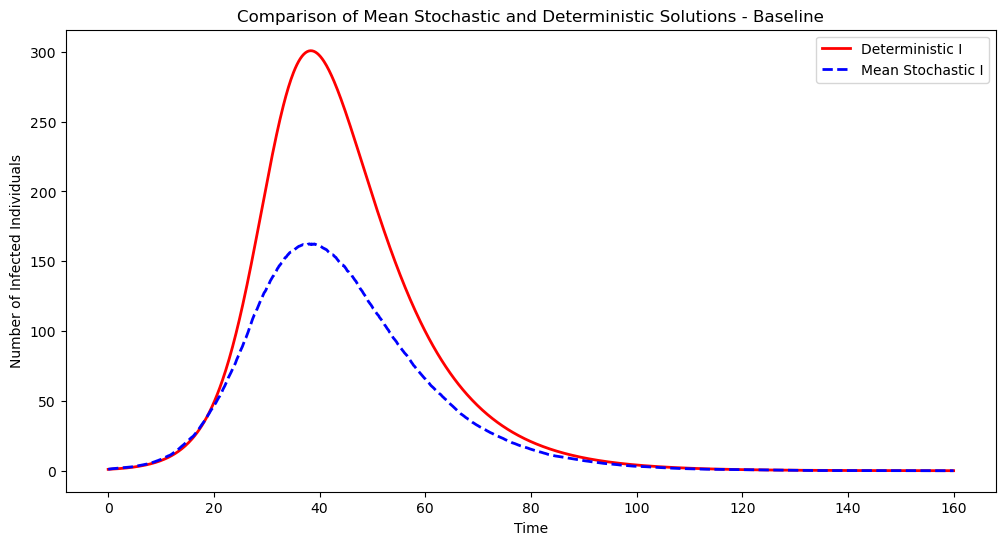

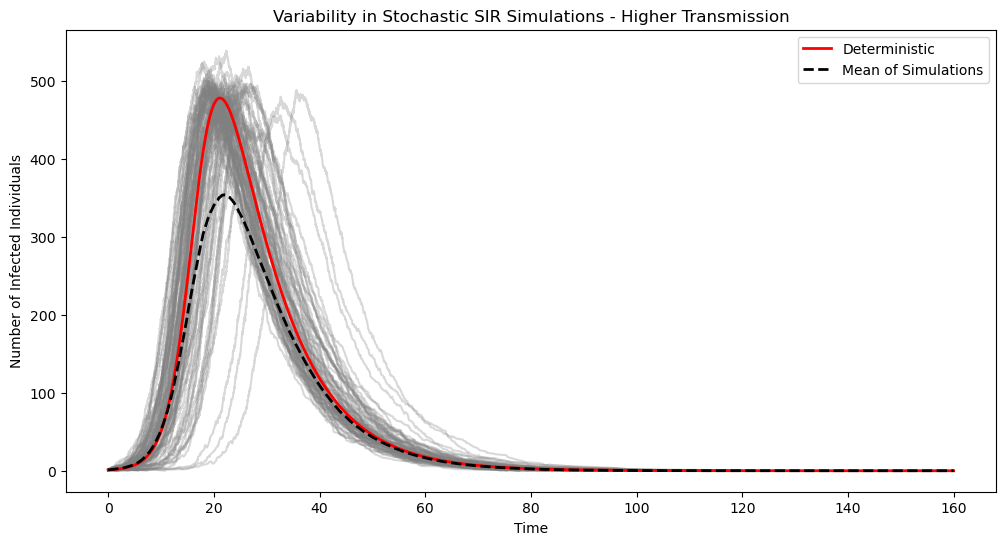

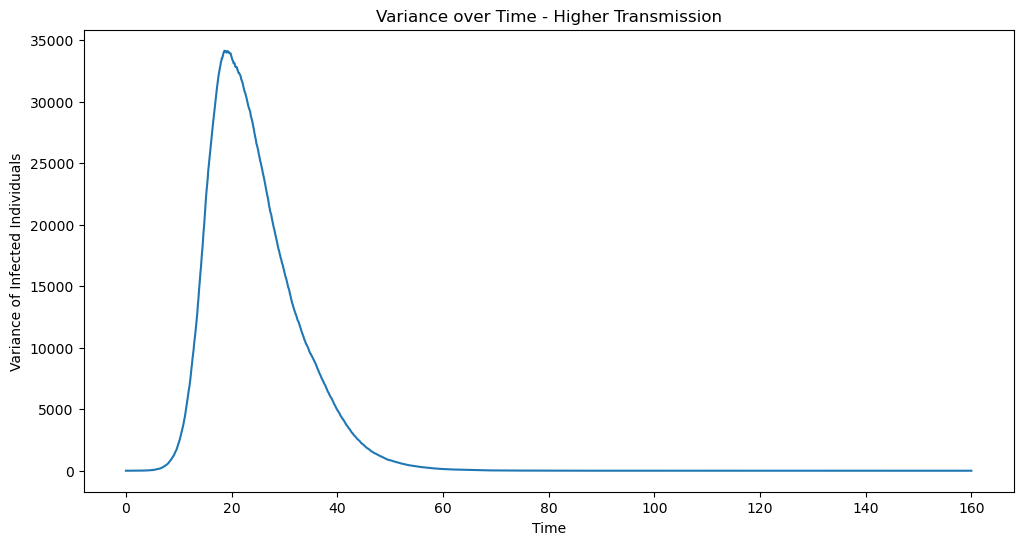

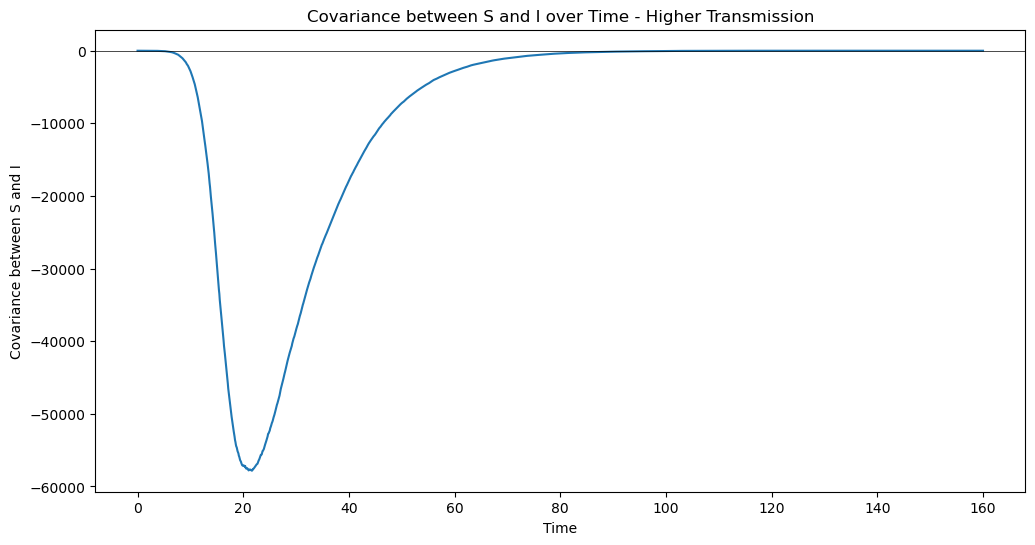

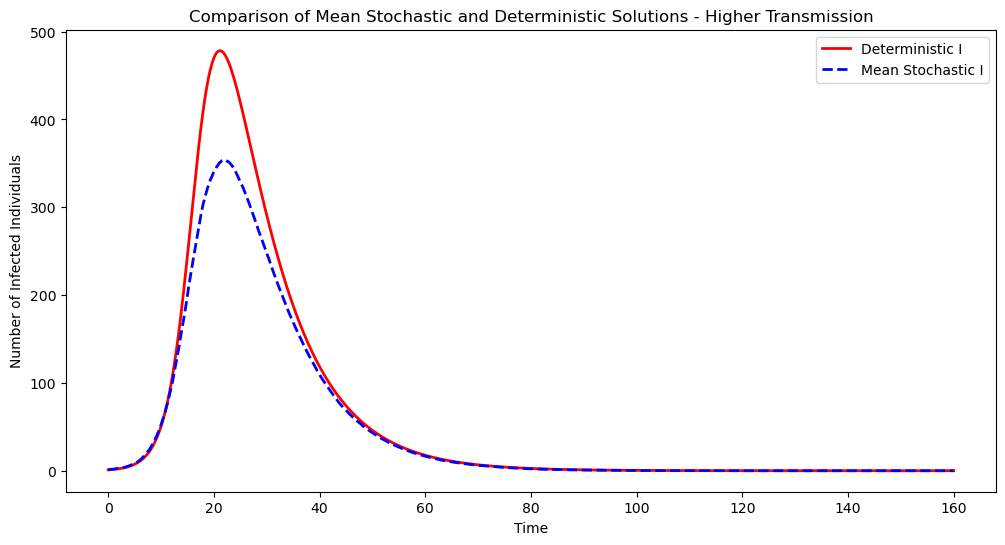

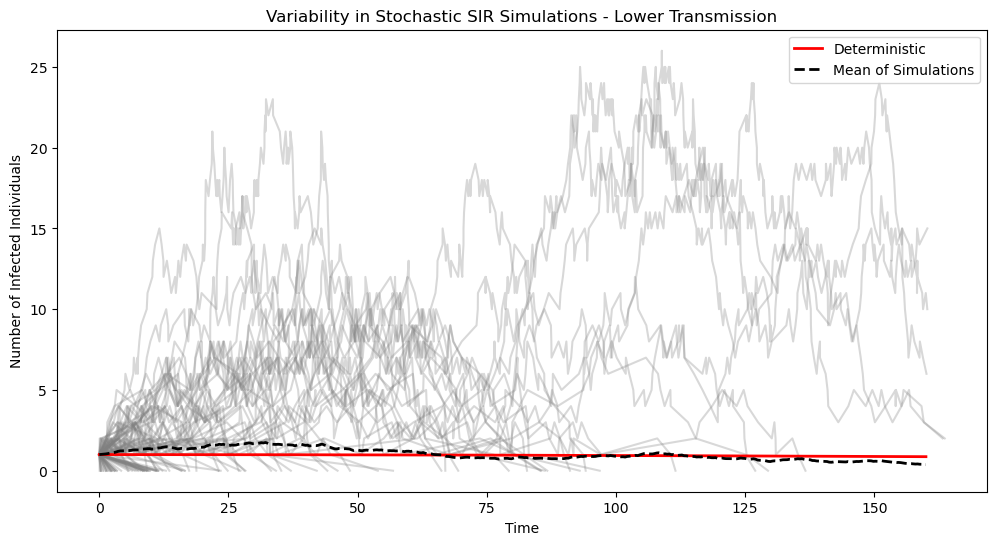

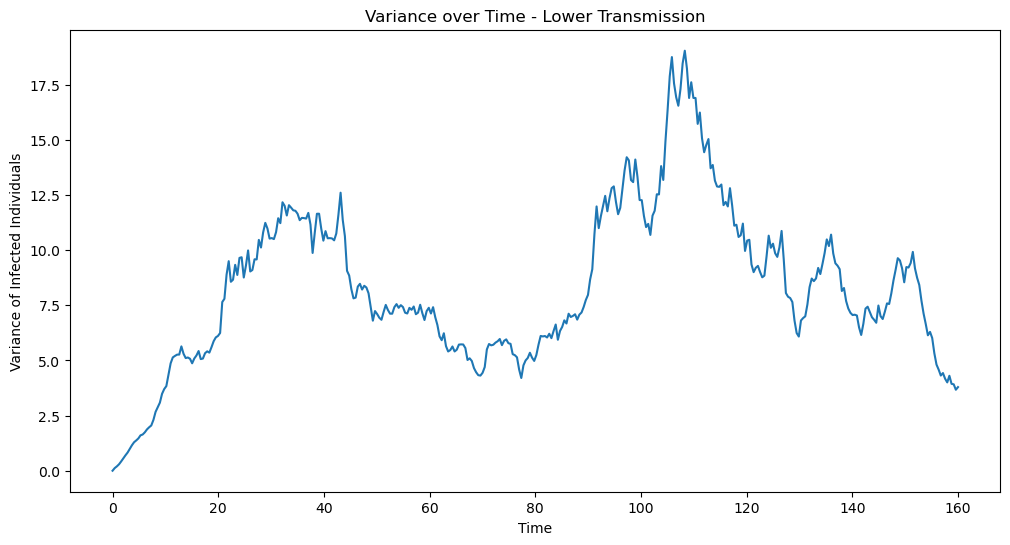

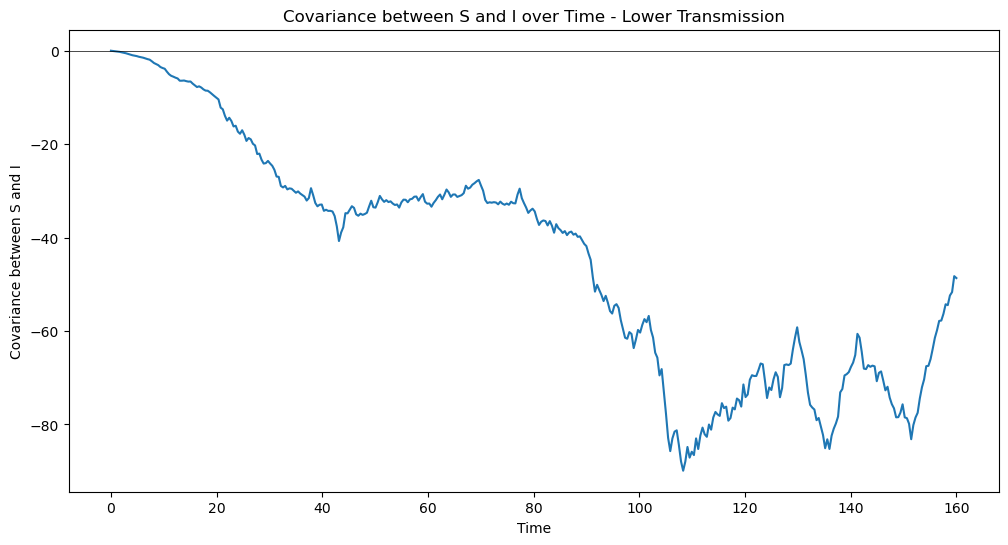

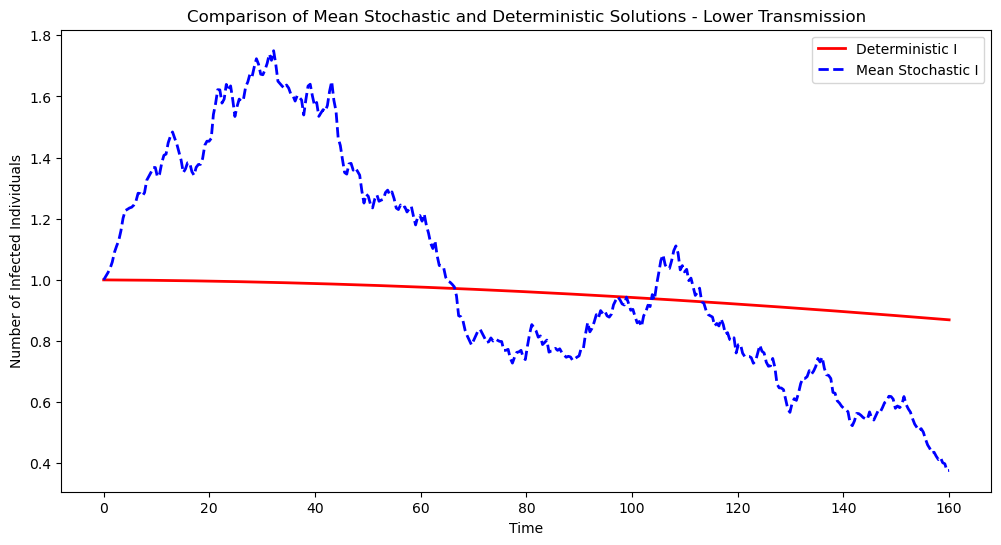

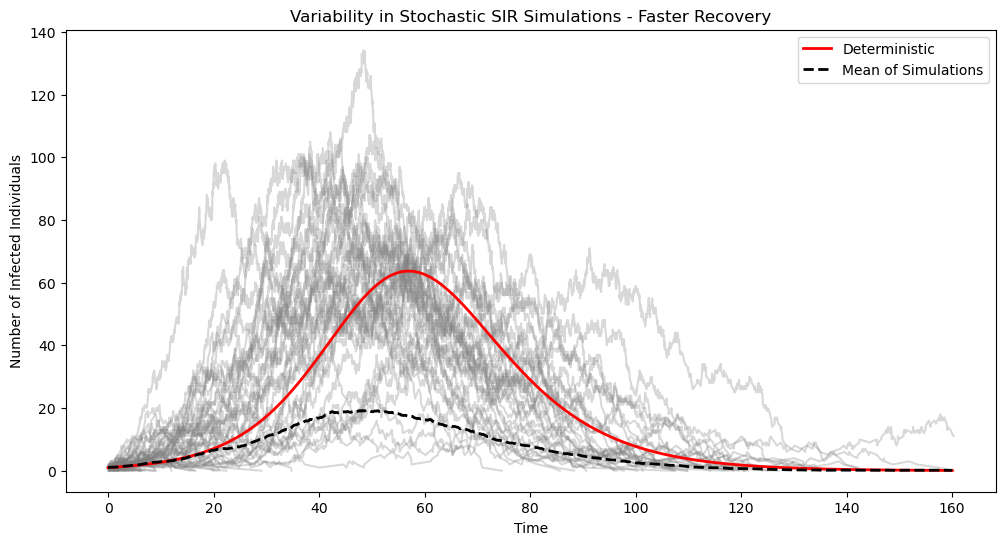

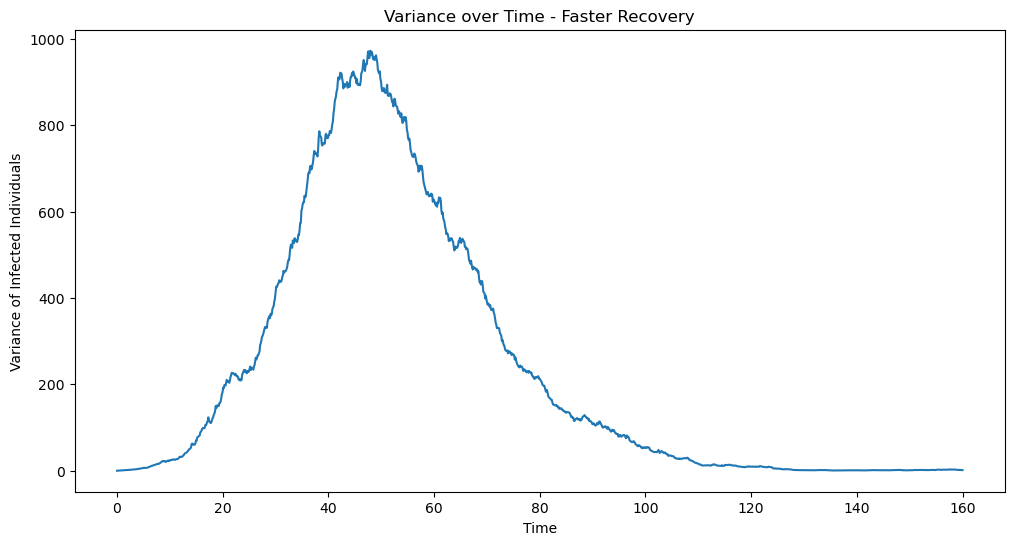

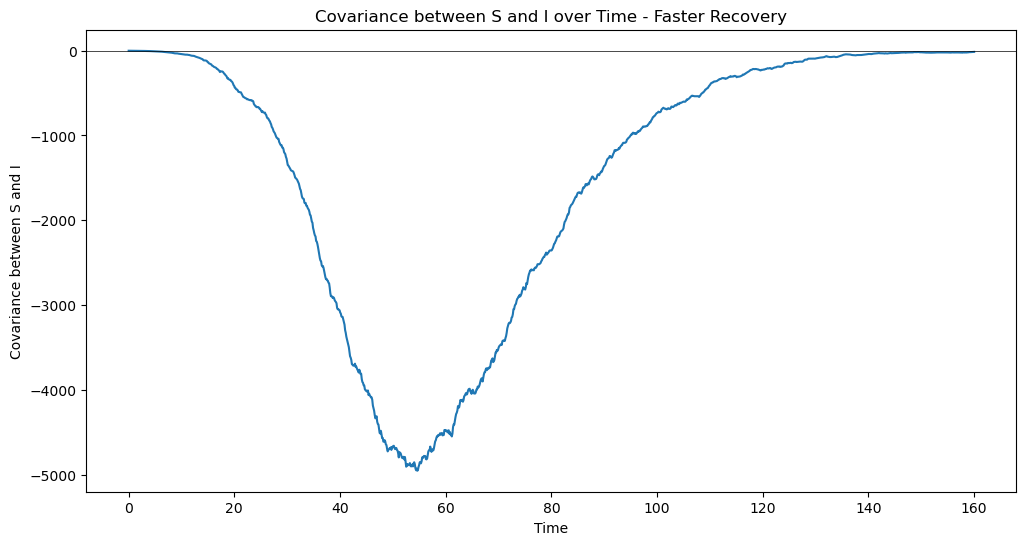

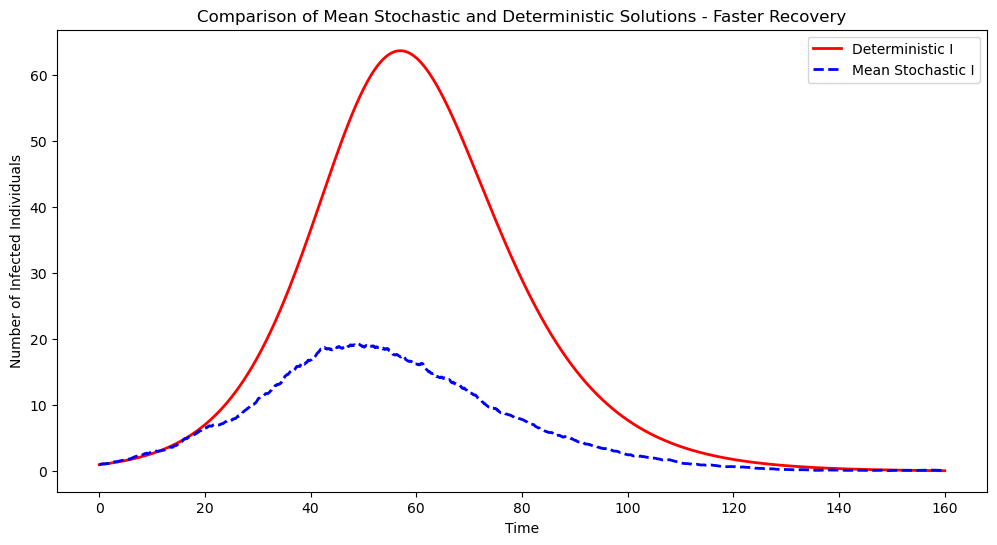

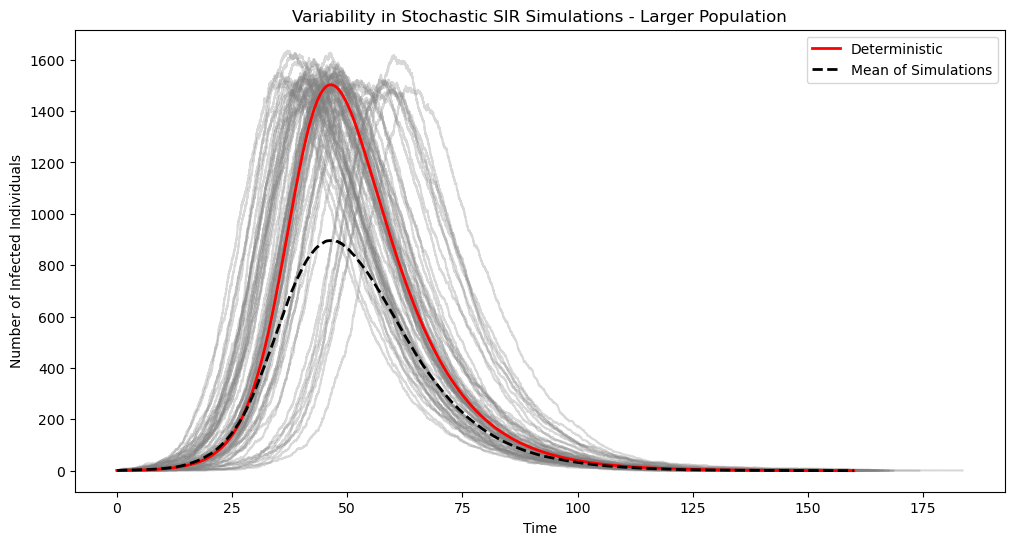

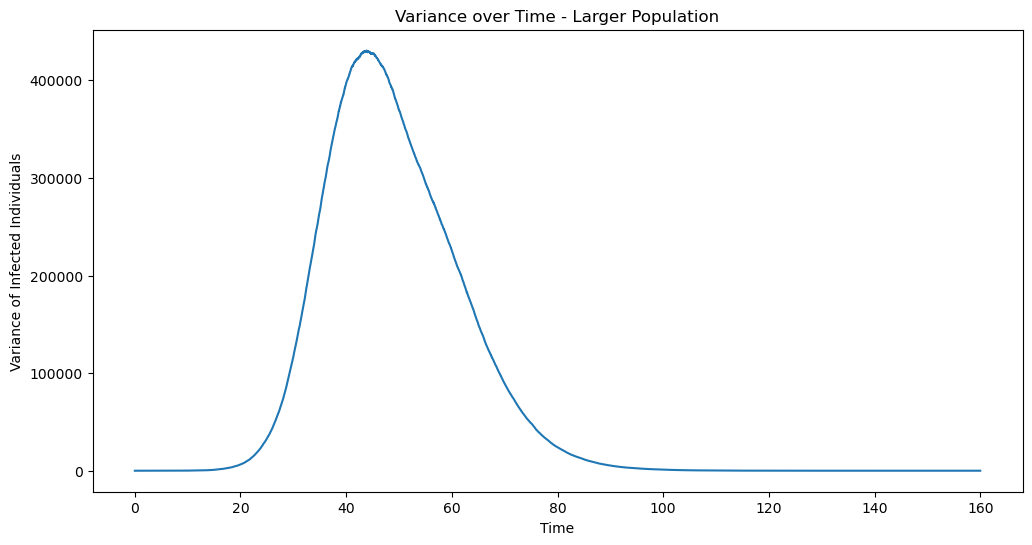

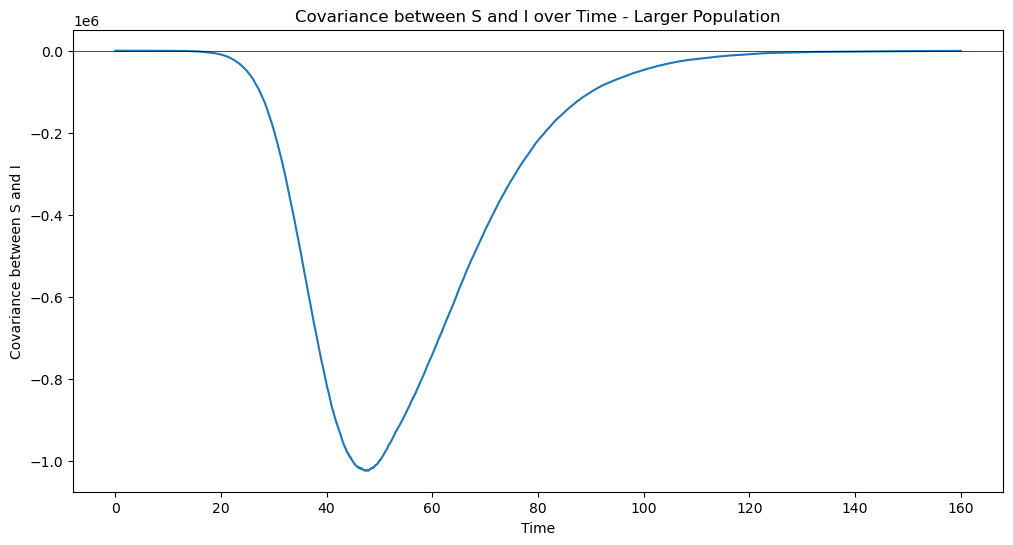

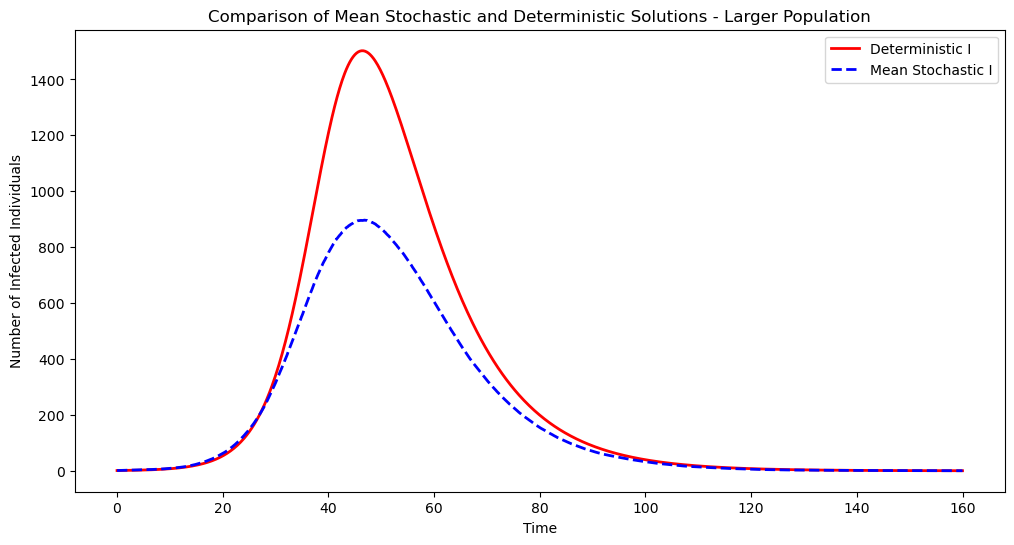

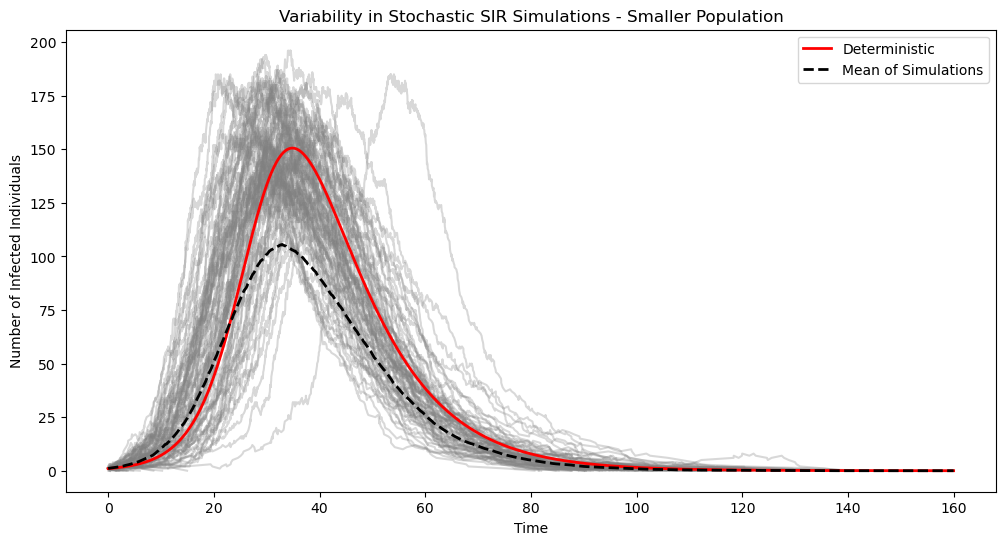

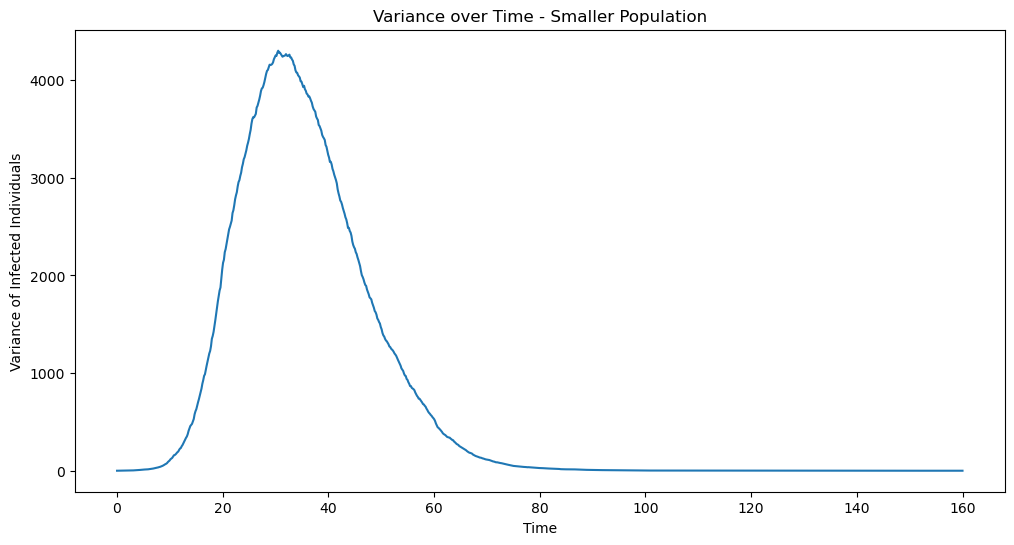

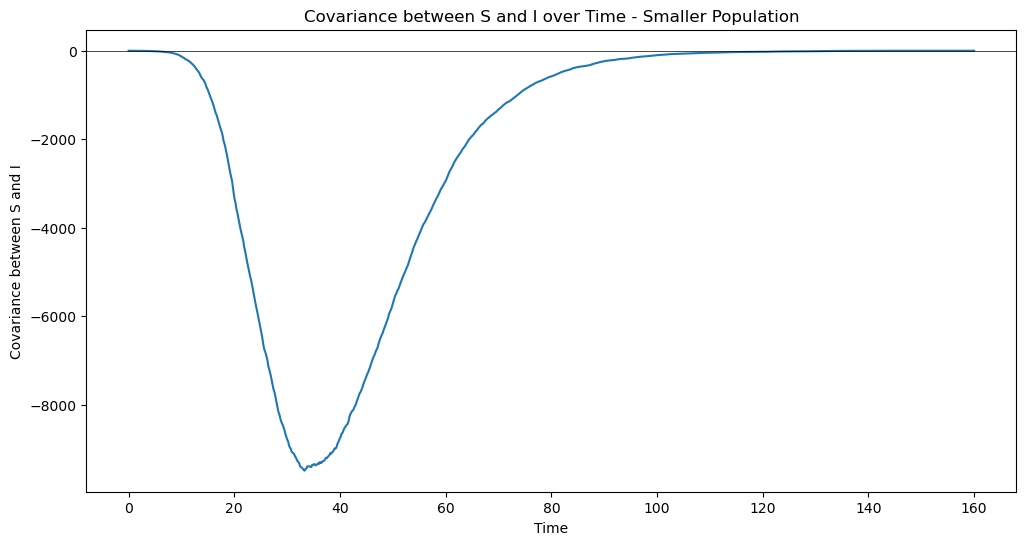

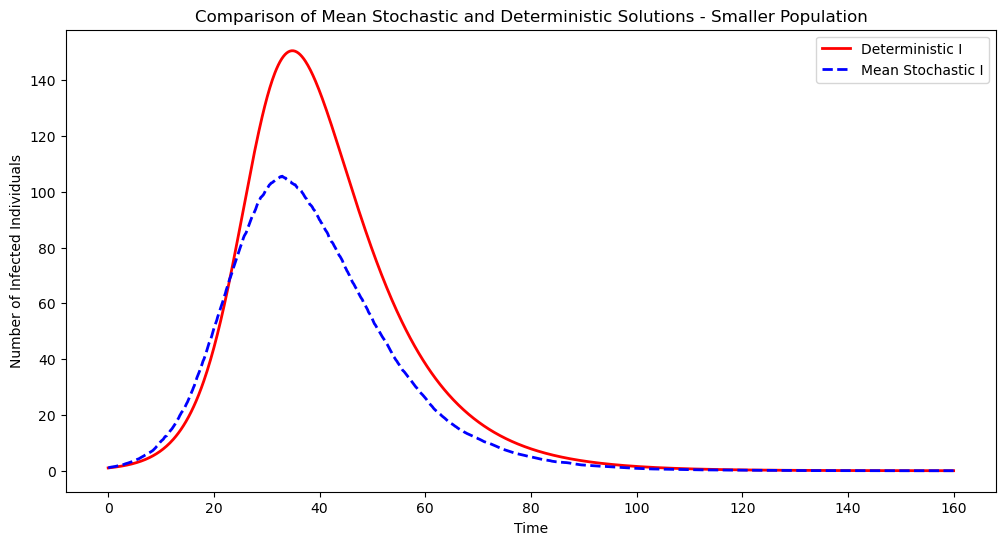

In [8]:
# Parameter sets
parameter_sets = [
    {'beta': 0.3, 'gamma': 0.1, 'N': 1000, 'label': 'Baseline'},
    {'beta': 0.5, 'gamma': 0.1, 'N': 1000, 'label': 'Higher Transmission'},
    {'beta': 0.1, 'gamma': 0.1, 'N': 1000, 'label': 'Lower Transmission'},
    {'beta': 0.3, 'gamma': 0.2, 'N': 1000, 'label': 'Faster Recovery'},
    {'beta': 0.3, 'gamma': 0.1, 'N': 5000, 'label': 'Larger Population'},
    {'beta': 0.3, 'gamma': 0.1, 'N': 500, 'label': 'Smaller Population'}
]

num_simulations = 100  # Number of stochastic simulations
t_max = 160  # Maximum time
t_det = np.linspace(0, t_max, 1000)  # Time points for deterministic solution

# Loop over parameter sets
for params in parameter_sets:
    beta = params['beta']
    gamma = params['gamma']
    N = params['N']
    label = params['label']
    
    S0 = N - 1
    I0 = 1
    R0 = 0

    # Solve deterministic SIR model
    y0 = [S0, I0, R0]
    ret = odeint(SIR_ode, y0, t_det, args=(beta, gamma, N))
    S_det, I_det, R_det = ret.T

    # Lists to store multiple simulation results
    I_values = []
    S_values = []
    time_values = []

    # Run multiple stochastic simulations
    for sim in range(num_simulations):
        times, S_vals, I_vals, _ = gillespie_SIR(beta, gamma, N, S0, I0, R0, t_max)
        I_values.append(I_vals)
        S_values.append(S_vals)
        time_values.append(times)

    # Align data for statistical analysis
    max_len = max(len(tv) for tv in time_values)
    time_grid = np.linspace(0, t_max, max_len)

    I_interp = np.zeros((num_simulations, max_len))
    S_interp = np.zeros((num_simulations, max_len))

    for i in range(num_simulations):
        I_interp[i, :] = np.interp(time_grid, time_values[i], I_values[i])
        S_interp[i, :] = np.interp(time_grid, time_values[i], S_values[i])

    # Compute statistics
    I_mean = np.mean(I_interp, axis=0)
    I_var = np.var(I_interp, axis=0)
    S_mean = np.mean(S_interp, axis=0)
    S_var = np.var(S_interp, axis=0)
    cov_SI = np.mean((S_interp - S_mean) * (I_interp - I_mean), axis=0)

    # Plotting results

    # Plot multiple stochastic simulations and deterministic solution
    plt.figure(figsize=(12, 6))
    for i in range(num_simulations):
        plt.plot(time_values[i], I_values[i], color='grey', alpha=0.3)
    plt.plot(t_det, I_det, 'r', lw=2, label='Deterministic')
    plt.plot(time_grid, I_mean, 'k--', lw=2, label='Mean of Simulations')
    plt.xlabel('Time')
    plt.ylabel('Number of Infected Individuals')
    plt.title(f'Variability in Stochastic SIR Simulations - {label}')
    plt.legend()
    plt.show()

    # Plot variance of I over time
    plt.figure(figsize=(12, 6))
    plt.plot(time_grid, I_var)
    plt.xlabel('Time')
    plt.ylabel('Variance of Infected Individuals')
    plt.title(f'Variance over Time - {label}')
    plt.show()

    # Plot covariance between S and I over time
    plt.figure(figsize=(12, 6))
    plt.plot(time_grid, cov_SI)
    plt.xlabel('Time')
    plt.ylabel('Covariance between S and I')
    plt.title(f'Covariance between S and I over Time - {label}')
    plt.axhline(0, color='black', lw=0.5)
    plt.show()

    # Comparison of mean stochastic and deterministic solutions
    plt.figure(figsize=(12, 6))
    plt.plot(t_det, I_det, 'r', lw=2, label='Deterministic I')
    plt.plot(time_grid, I_mean, 'b--', lw=2, label='Mean Stochastic I')
    plt.xlabel('Time')
    plt.ylabel('Number of Infected Individuals')
    plt.title(f'Comparison of Mean Stochastic and Deterministic Solutions - {label}')
    plt.legend()
    plt.show()

    # Additional analysis and plots can be added here


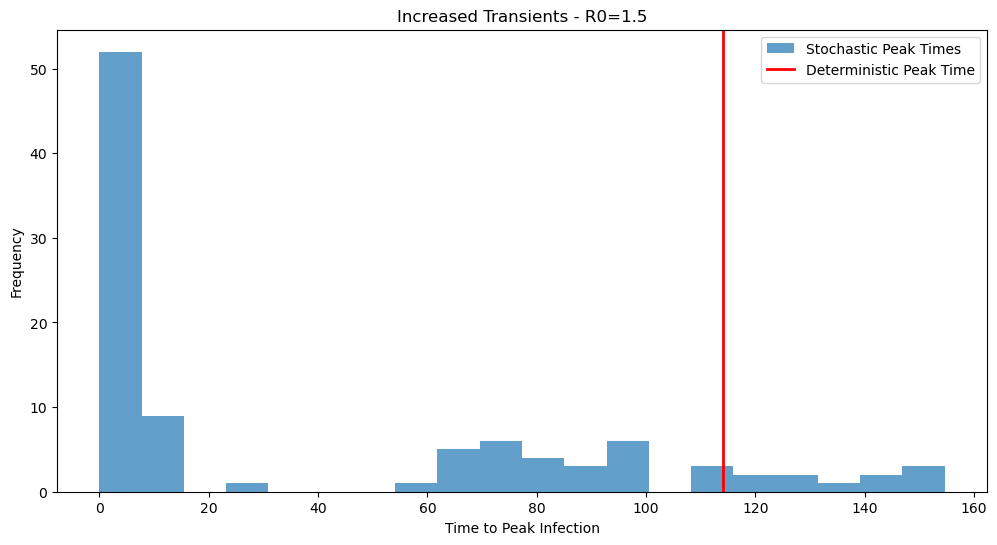

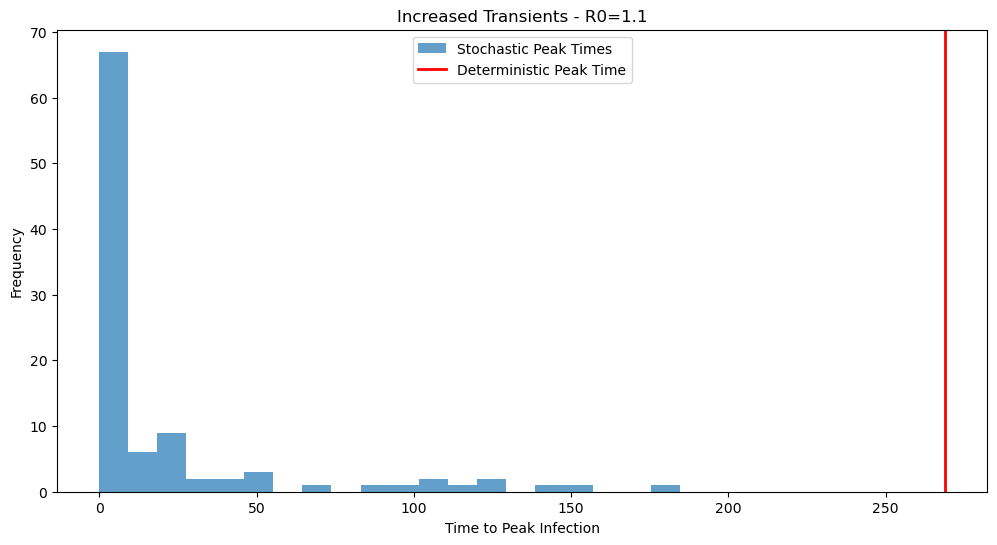

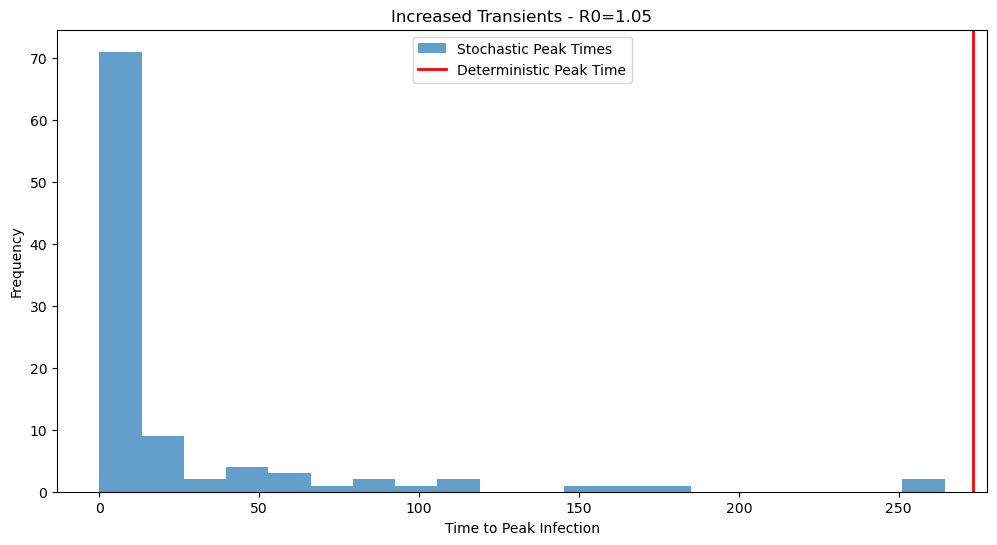

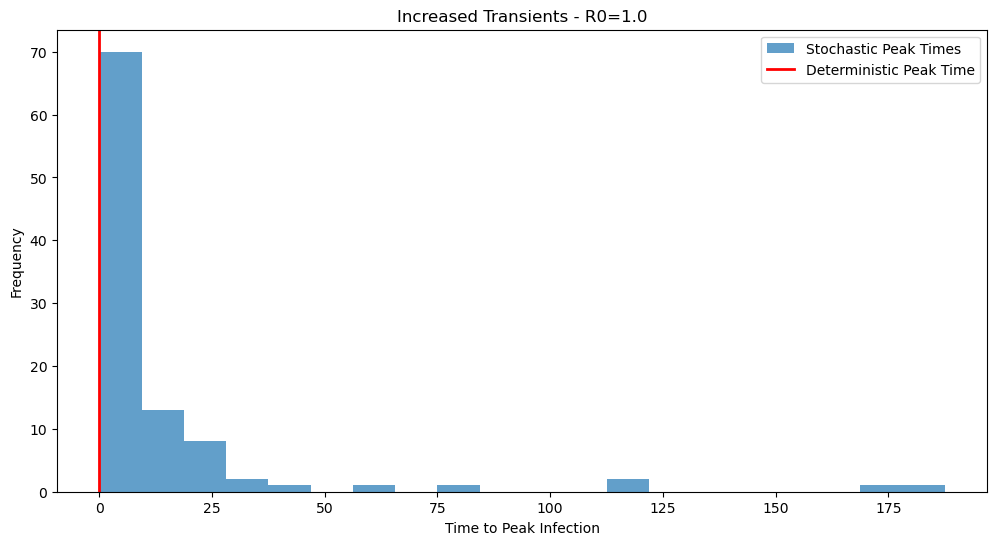

In [9]:
# Function to run Gillespie simulation and record peak time
def gillespie_SIR_peak_time(beta, gamma, N, S0, I0, R0, t_max):
    S = S0
    I = I0
    R = R0
    t = 0

    times = [t]
    I_vals = [I]
    peak_I = I
    peak_time = t

    while t < t_max and I > 0:
        a1 = beta * S * I / N
        a2 = gamma * I
        a0 = a1 + a2

        if a0 == 0:
            break

        r1 = np.random.uniform()
        delta_t = -np.log(r1) / a0
        t += delta_t

        r2 = np.random.uniform()
        if r2 < a1 / a0:
            S -= 1
            I += 1
        else:
            I -= 1
            R += 1

        times.append(t)
        I_vals.append(I)

        if I > peak_I:
            peak_I = I
            peak_time = t

    return np.array(times), np.array(I_vals), peak_time

parameter_sets = [
    {'beta': 0.15, 'gamma': 0.1, 'N': 1000, 'label': 'R0=1.5'},
    {'beta': 0.11, 'gamma': 0.1, 'N': 1000, 'label': 'R0=1.1'},
    {'beta': 0.105, 'gamma': 0.1, 'N': 1000, 'label': 'R0=1.05'},
    {'beta': 0.1, 'gamma': 0.1, 'N': 1000, 'label': 'R0=1.0'},
]

num_simulations = 100
t_max = 500
I0 = 1

for params in parameter_sets:
    beta = params['beta']
    gamma = params['gamma']
    N = params['N']
    label = params['label']
    S0 = N - I0

    # Solve deterministic model
    t_det = np.linspace(0, t_max, 1000)
    y0 = [S0, I0, 0]
    ret = odeint(SIR_ode, y0, t_det, args=(beta, gamma, N))
    S_det, I_det, R_det = ret.T
    peak_time_det = t_det[np.argmax(I_det)]

    peak_times_stoch = []
    I_values = []
    time_values = []

    for sim in range(num_simulations):
        times, I_vals, peak_time = gillespie_SIR_peak_time(beta, gamma, N, S0, I0, 0, t_max)
        peak_times_stoch.append(peak_time)
        I_values.append(I_vals)
        time_values.append(times)

    # Plot histogram of peak times
    plt.figure(figsize=(12, 6))
    plt.hist(peak_times_stoch, bins=20, alpha=0.7, label='Stochastic Peak Times')
    plt.axvline(peak_time_det, color='red', lw=2, label='Deterministic Peak Time')
    plt.xlabel('Time to Peak Infection')
    plt.ylabel('Frequency')
    plt.title(f'Increased Transients - {label}')
    plt.legend()
    plt.show()


N=500, R0=1.00, Extinction Probability=1.000
N=500, R0=1.04, Extinction Probability=1.000
N=500, R0=1.07, Extinction Probability=1.000
N=500, R0=1.11, Extinction Probability=1.000
N=500, R0=1.15, Extinction Probability=1.000
N=500, R0=1.19, Extinction Probability=1.000
N=500, R0=1.23, Extinction Probability=1.000
N=500, R0=1.26, Extinction Probability=1.000
N=500, R0=1.30, Extinction Probability=1.000
N=500, R0=1.34, Extinction Probability=1.000
N=500, R0=1.38, Extinction Probability=1.000
N=500, R0=1.41, Extinction Probability=1.000
N=500, R0=1.45, Extinction Probability=1.000
N=500, R0=1.49, Extinction Probability=1.000
N=500, R0=1.52, Extinction Probability=1.000
N=500, R0=1.56, Extinction Probability=1.000
N=500, R0=1.60, Extinction Probability=1.000
N=500, R0=1.64, Extinction Probability=1.000
N=500, R0=1.67, Extinction Probability=1.000
N=500, R0=1.71, Extinction Probability=1.000
N=500, R0=1.75, Extinction Probability=1.000
N=1000, R0=1.00, Extinction Probability=1.000
N=1000, R

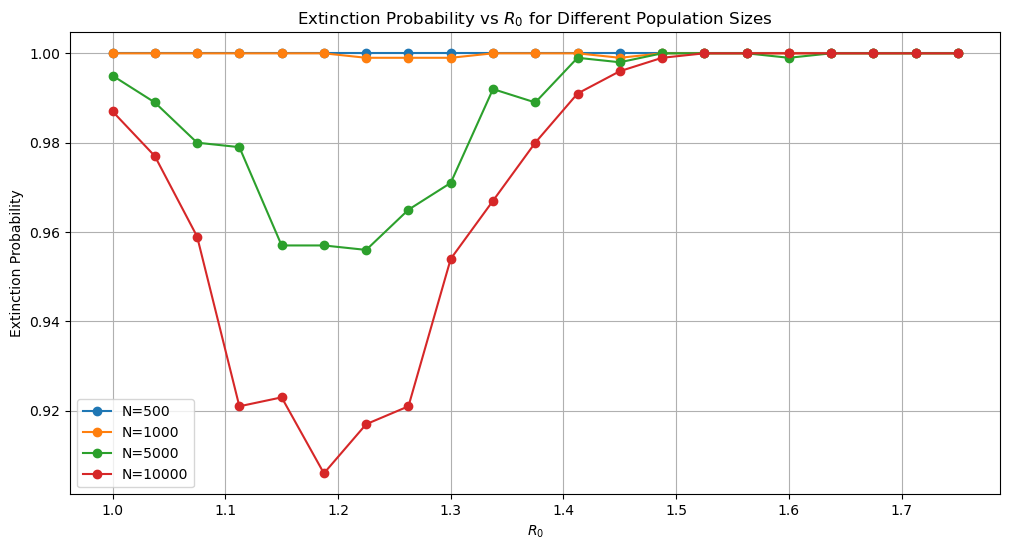

In [10]:
# Gillespie algorithm function to check for extinction
def gillespie_SIR_extinction(beta, gamma, N, S0, I0, R0, t_max):
    S = S0
    I = I0
    R = R0
    t = 0

    while t < t_max:
        if I == 0:
            # Extinction occurred
            return True
        # Calculate rates
        a1 = beta * S * I / N  # Infection rate
        a2 = gamma * I         # Recovery rate
        a0 = a1 + a2           # Total rate

        if a0 == 0:
            break

        # Time to next event
        r1 = np.random.uniform()
        delta_t = -np.log(r1) / a0
        t += delta_t

        # Determine event
        r2 = np.random.uniform()
        if r2 < a1 / a0:
            # Infection event
            S -= 1
            I += 1
        else:
            # Recovery event
            I -= 1
            R += 1

    # If simulation ends without I reaching 0, extinction did not occur
    return False

# Parameters
gamma = 0.1  # Fixed recovery rate
t_max = 500
n_simulations = 1000  # Number of simulations per parameter set
I0 = 1  # Initial number of infected individuals

# R0 and N values to test
R0_values = np.linspace(1.0, 1.75, 21)  # From 1.0 to 3.0 in steps of 0.1
N_values = [500, 1000, 5000, 10000]

# Store results
extinction_probabilities = {}

for N in N_values:
    extinction_probabilities[N] = []
    S0 = N - I0
    for R0 in R0_values:
        beta = R0 * gamma  # Adjust beta to get desired R0
        extinctions = 0
        for _ in range(n_simulations):
            extinct = gillespie_SIR_extinction(beta, gamma, N, S0, I0, 0, t_max)
            if extinct:
                extinctions += 1
        P_extinct = extinctions / n_simulations
        extinction_probabilities[N].append(P_extinct)
        print(f"N={N}, R0={R0:.2f}, Extinction Probability={P_extinct:.3f}")

# Plotting the results
plt.figure(figsize=(12, 6))
for N in N_values:
    plt.plot(R0_values, extinction_probabilities[N], marker='o', label=f'N={N}')
plt.xlabel('$R_0$')
plt.ylabel('Extinction Probability')
plt.title('Extinction Probability vs $R_0$ for Different Population Sizes')
plt.legend()
plt.grid(True)
plt.show()


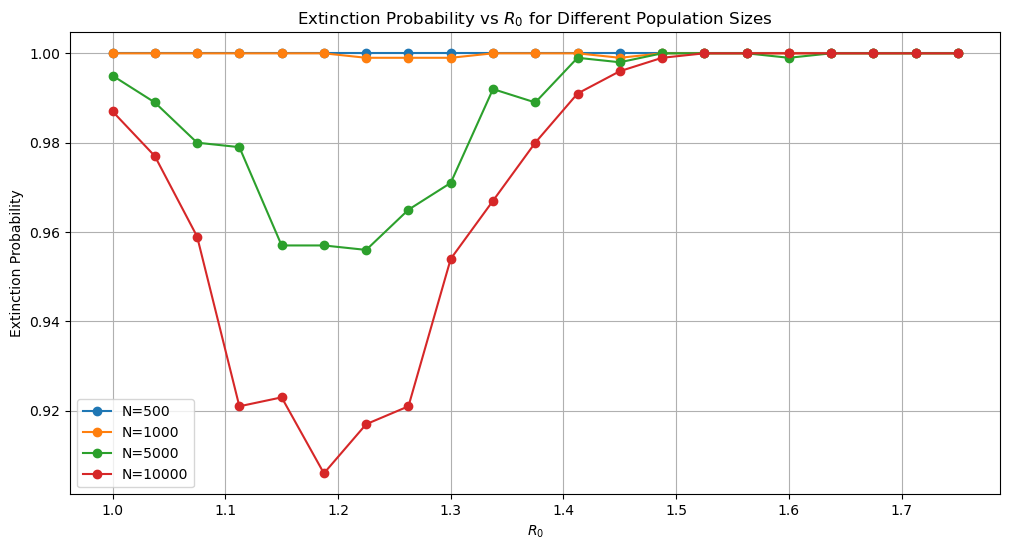

In [11]:
# Plotting the results
plt.figure(figsize=(12, 6))
for N in N_values:
    plt.plot(R0_values, extinction_probabilities[N], marker='o', label=f'N={N}')
plt.xlabel('$R_0$')
plt.ylabel('Extinction Probability')
plt.title('Extinction Probability vs $R_0$ for Different Population Sizes')
plt.legend()
plt.grid(True)
plt.show()

# Spatial Models - Networks

In [12]:
# Import the csv file
df = pd.read_csv('transmission_network.csv', sep=';')
df = df.rename(columns={df.columns[0]:'nodes'})

# Create graph object and add nodes to it
Graph_obj = nx.Graph()
nodes = df['nodes'].tolist()
Graph_obj.add_nodes_from(nodes)

# Add edges between nodes based on the csv-file
for _, row in df.iterrows():
    source_node = row['nodes']
    for col_name, edge_value in row.items():
        if col_name != 'nodes' and edge_value != 0:
            Graph_obj.add_edge(source_node, int(col_name))

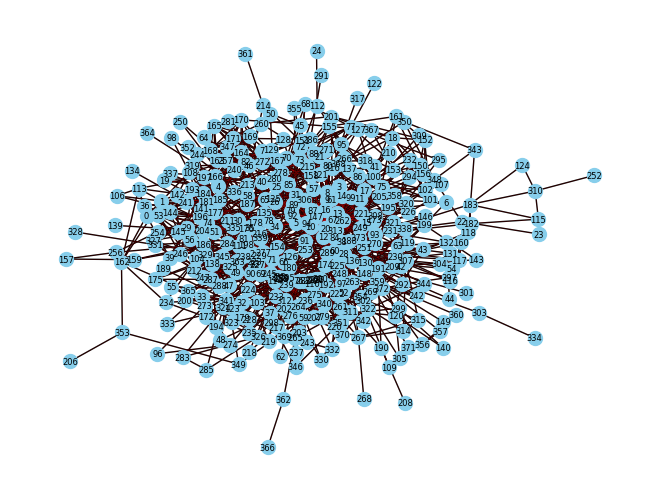

In [13]:
# Relabel the nodes
Graph_obj = nx.convert_node_labels_to_integers(Graph_obj, first_label=0)

# create a layout for the nodes
pos = nx.kamada_kawai_layout(Graph_obj)

# draw the nodes and edges
nx.draw(Graph_obj, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_color='black')
nx.draw_networkx_edges(Graph_obj, pos, edge_color='red', width=0.1)

# display the graph
plt.axis('off')
# plt.title("Network Visualization")
plt.savefig('Figures/Network_input_data.png')
plt.show()

In [14]:
# Generate SIR model object
SIR_model = ep.SIRModel(Graph_obj)

# Set parameter values
betas = np.linspace(0.1, 3, 101)
gammas = np.linspace(0.01, 1, 101)
percentage_infected = 0.01
nr_iterations = 100

# Pre-allocate variables.
S_store = np.zeros((len(betas), len(gammas), nr_iterations))
I_store = np.zeros((len(betas), len(gammas), nr_iterations))
R_store = np.zeros((len(betas), len(gammas), nr_iterations))

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected)

for beta_ix, beta in enumerate(betas):
    for gamma_ix, gamma in enumerate(gammas):
        # (Re)set every node as susceptible
        for node in Graph_obj.nodes():
            SIR_model.status[node] = 0
            
        # Set model configurations
        cfg.add_model_parameter('beta', beta)
        cfg.add_model_parameter('gamma', gamma)
        SIR_model.set_initial_status(cfg)
        iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
        trends = SIR_model.build_trends(iterations)
        
        # Extract values based on updated structure
        node_counts = trends[0]['trends']['node_count']
        S = node_counts[0]
        I = node_counts[1]
        R = node_counts[2]

        # Store the sums for averages
        S_store[beta_ix, gamma_ix] = S
        I_store[beta_ix, gamma_ix] = I
        R_store[beta_ix, gamma_ix] = R

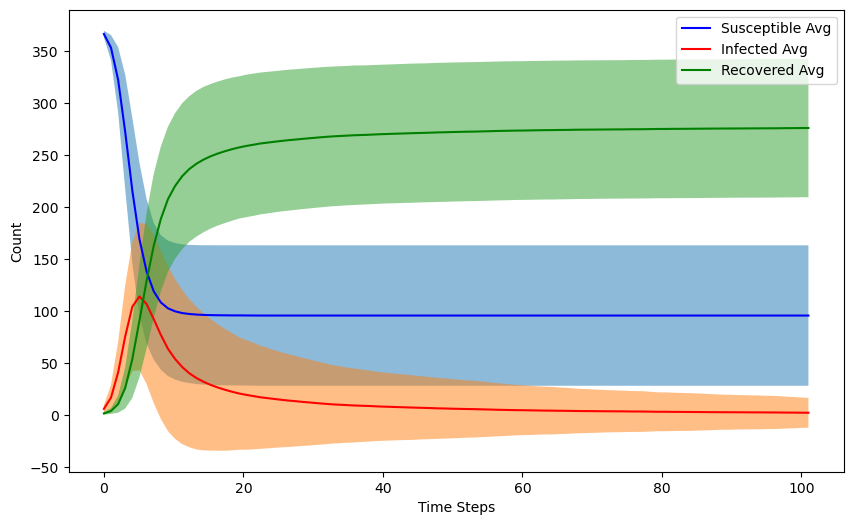

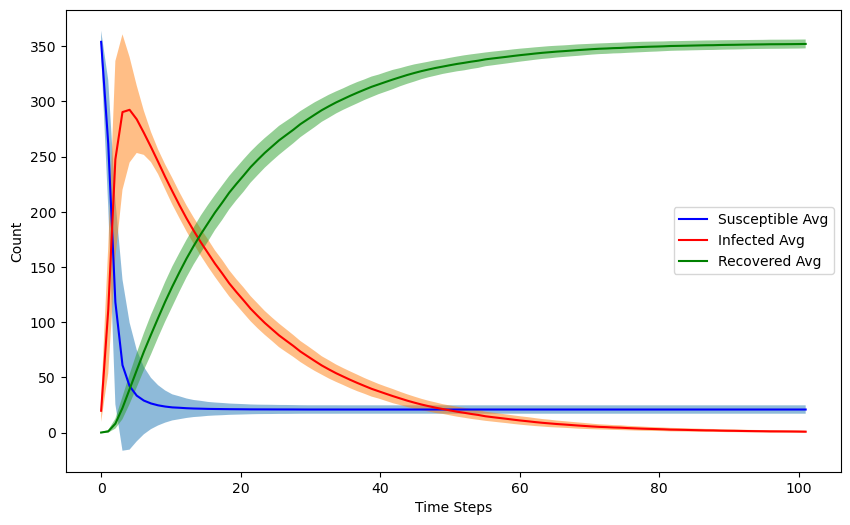

In [15]:
beta_index = 5
Gamma_index = 5

S_mean_0 = np.mean(S_store[beta_index], axis=0)
I_mean_0 = np.mean(I_store[beta_index], axis=0)
R_mean_0 = np.mean(R_store[beta_index], axis=0)
S_std_0 = np.std(S_store[beta_index], axis=0)
I_std_0 = np.std(I_store[beta_index], axis=0)
R_std_0 = np.std(R_store[beta_index], axis=0)

S_mean_1 = np.mean(S_store[:, Gamma_index], axis=0)
I_mean_1 = np.mean(I_store[:, Gamma_index], axis=0)
R_mean_1 = np.mean(R_store[:, Gamma_index], axis=0)
S_std_1 = np.std(S_store[:, Gamma_index], axis=0)
I_std_1 = np.std(I_store[:, Gamma_index], axis=0)
R_std_1 = np.std(R_store[:, Gamma_index], axis=0)

x = np.linspace(0, 101, 100)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S_mean_0, label="Susceptible Avg", color='blue')
plt.fill_between(x, S_mean_0 - S_std_0,S_mean_0 + S_std_0, alpha=0.5) 
plt.plot(x, I_mean_0, label="Infected Avg", color='red')
plt.fill_between(x, I_mean_0 - I_std_0,I_mean_0 + I_std_0, alpha=0.5) 
plt.plot(x, R_mean_0, label="Recovered Avg", color='green')
plt.fill_between(x, R_mean_0 - R_std_0,R_mean_0 + R_std_0, alpha=0.5) 
# plt.title(fr"Average SIR Dynamics over Different values of $\gamma$ with $\beta = {betas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.savefig(f'Figures/Average_dynamics_with_Gamma_{gammas[Gamma_index]}_and_varying_betas.png')
plt.show()

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S_mean_1, label="Susceptible Avg", color='blue')
plt.fill_between(x, S_mean_1 - S_std_1,S_mean_1 + S_std_1, alpha=0.5) 
plt.plot(x, I_mean_1, label="Infected Avg", color='red')
plt.fill_between(x, I_mean_1 - I_std_1,I_mean_1 + I_std_1, alpha=0.5) 
plt.plot(x, R_mean_1, label="Recovered Avg", color='green')
plt.fill_between(x, R_mean_1 - R_std_1,R_mean_1 + R_std_1, alpha=0.5) 
# plt.title(fr"Average SIR Dynamics over Different values of $\beta$ with $\gamma = {gammas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.savefig(f'Figures/Average_dynamics_with_beta_{betas[beta_index]}_and_varying_gammas.png')
plt.show()

## Similar networks

In [16]:
def statistic_func(Graph):
    # Pre-allocating return variable
    stats = {}
    
    stats['Nr_of_nodes'] = Graph.number_of_nodes()
    stats['Nr_of_edges'] = Graph.number_of_edges()
        

    degrees = [degree for degree in Graph.degree()]
    stats['Average_degree'] = np.mean(degrees)
    
    
    if degrees:
        stats['average_clustering_coefficient'] = nx.average_clustering(Graph)
        stats['density'] = nx.density(Graph)
        
        degree_centralities = nx.degree_centrality(Graph)
        stats['average_degree_centrality'] = np.mean(list(degree_centralities.values()))
        
        betweenness_centralities = nx.betweenness_centrality(Graph)
        stats['average_betweenness_centrality'] = np.mean(list(betweenness_centralities.values()))
        
        closeness_centrality = nx.closeness_centrality(Graph)
        stats['average_closeness_centrality'] = np.mean(list(closeness_centrality.values()))
        
        if nx.is_connected(Graph):
            stats['diameter'] = nx.diameter(Graph)
            stats['average_shortest_path_length'] = nx.average_shortest_path_length(Graph)
            
        else:
            stats['diameter'] = None
            stats['average_shortest_path_length'] = None
    else:
        stats['average_clustering_coefficient'] = None
        stats['density'] = None
        stats['average_degree_centrality'] = None
        stats['average_betweenness_centrality'] = None
        stats['average_closeness_centrality'] = None

    return stats

### Erdös-Rénji Network


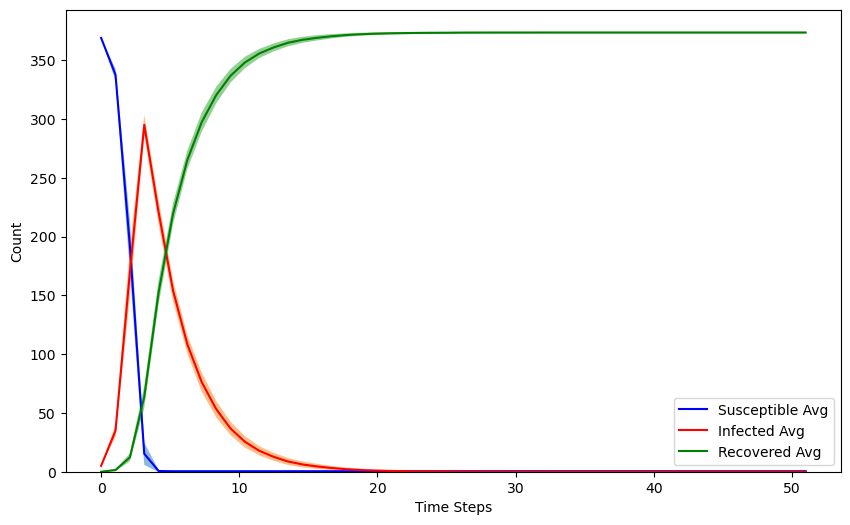

Nr_of_edges            Average_degree            \
                   mean        std           mean       std   
Nr_of_nodes                                                   
374             1253.95  34.909804      96.602807  0.093342   

            average_clustering_coefficient             density          \
                                      mean       std      mean     std   
Nr_of_nodes                                                              
374                               0.017357  0.003385  0.017978  0.0005   

            average_degree_centrality         average_betweenness_centrality  \
                                 mean     std                           mean   
Nr_of_nodes                                                                    
374                          0.017978  0.0005                       0.006224   

                      average_closeness_centrality            diameter  \
                  std                         mean       std      mean   
Nr_of_nodes                                                              
374          0.000114                     0.302146  0.004201  6.188406   

                      average_shortest_path_length            
                  std                         mean       std  
Nr_of_nodes                                                   
374          0.393901                      3.31495  0.041606

In [17]:
# Parameters such that the number of edges is close to the 1265 edges of the sociopatters data set
size = 374
p = 0.018
runs = 100

# Set parameter values
beta = 1.5
gamma = 0.3
percentage_infected = 5/374
nr_iterations = 50
x = np.linspace(0, nr_iterations+1, nr_iterations)
results_ER = []

# Pre-allocate variables.
S_ER = np.zeros((runs, nr_iterations))
I_ER = np.zeros((runs, nr_iterations))
R_ER = np.zeros((runs, nr_iterations))

for run in range(runs):
    # Generate Erdos-Renyi graph similar to the given model
    Graph_ER = nx.erdos_renyi_graph(size, p)
    
    stats_ER = statistic_func(Graph_ER)
    results_ER.append(stats_ER)

    # Generate SIR model object
    SIR_model = ep.SIRModel(Graph_ER)
    
    # Run experiment
    cfg = mc.Configuration()
    cfg.add_model_parameter("percentage_infected", percentage_infected)


    # Set every node as susceptible
    for node in Graph_obj.nodes():
        SIR_model.status[node] = 0
        
    # Set model configurations
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('gamma', gamma)
    SIR_model.set_initial_status(cfg)
    
    for t in range(nr_iterations):
        iteration = SIR_model.iteration(node_status=True)

        # Extract values based on updated structure
        node_counts = SIR_model.build_trends([iteration])[0]['trends']['node_count']
        S_ER[run, t] = node_counts[0][-1]
        I_ER[run, t] = node_counts[1][-1]
        R_ER[run, t] = node_counts[2][-1]
        

S_ER_mean = np.mean(S_ER, axis=0)
S_ER_std = np.std(S_ER, axis=0)
I_ER_mean = np.mean(I_ER, axis=0)
I_ER_std = np.std(I_ER, axis=0)
R_ER_mean = np.mean(R_ER, axis=0)
R_ER_std = np.std(R_ER, axis=0)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S_ER_mean, label="Susceptible Avg", color='blue')
plt.fill_between(x, S_ER_mean - S_ER_std, S_ER_mean + S_ER_std, alpha=0.5)
plt.plot(x, I_ER_mean, label="Infected Avg", color='red')
plt.fill_between(x, I_ER_mean - I_ER_std, I_ER_mean + I_ER_std, alpha=0.5)
plt.plot(x, R_ER_mean, label="Recovered Avg", color='green')
plt.fill_between(x, R_ER_mean - R_ER_std, R_ER_mean + R_ER_std, alpha=0.5)
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.ylim(bottom=0)
plt.savefig(f'Figures/Erdos_Reyni_size_{size}_probability_{p}.png')
plt.show()

df_ER = pd.DataFrame(results_ER)
custom_summary_ER = df_ER.groupby(df_ER.columns[0]).agg(['mean', 'std'])
display(custom_summary_ER)

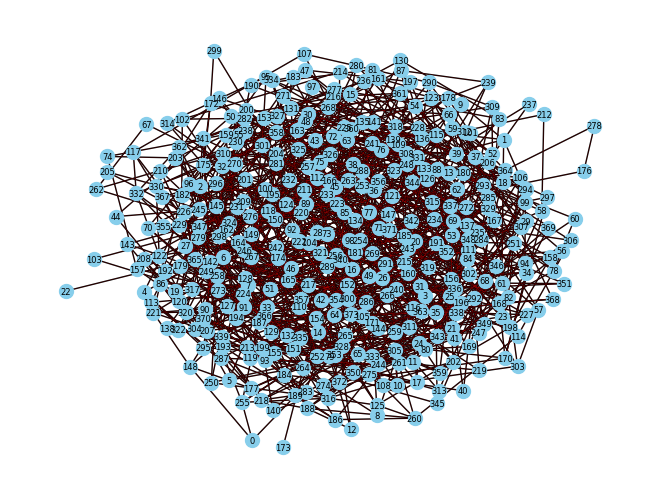

In [18]:
Graph_ER = nx.erdos_renyi_graph(size, p)

# Relabel the nodes
Graph_ER = nx.convert_node_labels_to_integers(Graph_ER, first_label=0)

# create a layout for the nodes
pos = nx.kamada_kawai_layout(Graph_ER)

# draw the nodes and edges
nx.draw(Graph_ER, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_color='black')
nx.draw_networkx_edges(Graph_ER, pos, edge_color='red', width=0.1)

# display the graph
plt.axis('off')
# plt.title("Network Visualization")
plt.savefig('Figures/Network_Erdos_Reyni.png')
plt.show()

## Watts-Stograz network

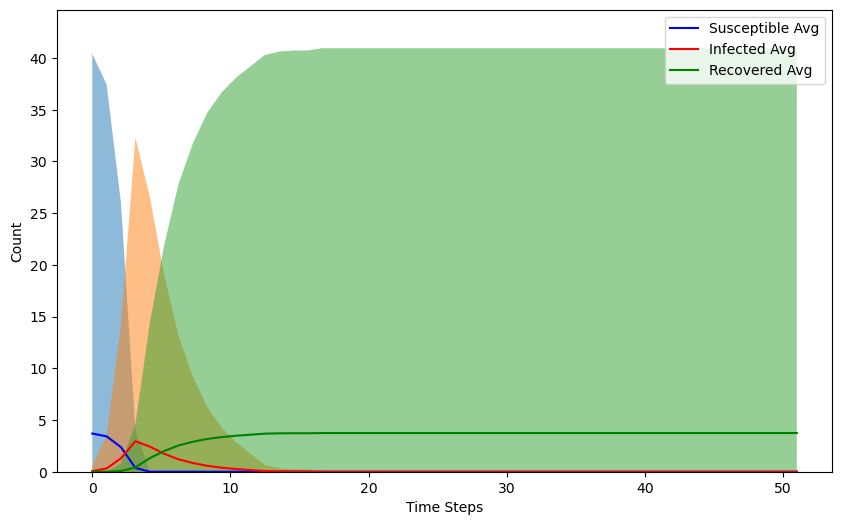

Nr_of_edges      Average_degree       \
                   mean  std           mean  std   
Nr_of_nodes                                        
374              1122.0  0.0          96.25  0.0   

            average_clustering_coefficient             density       \
                                      mean       std      mean  std   
Nr_of_nodes                                                           
374                               0.066869  0.006616  0.016086  0.0   

            average_degree_centrality      average_betweenness_centrality  \
                                 mean  std                           mean   
Nr_of_nodes                                                                 
374                          0.016086  0.0                       0.007008   

                      average_closeness_centrality           diameter       \
                  std                         mean       std     mean  std   
Nr_of_nodes                                                                  
374          0.000034                     0.277855  0.000967      6.0  0.0   

            average_shortest_path_length            
                                    mean       std  
Nr_of_nodes                                         
374                             3.607143  0.012546

In [19]:
# Parameters such that the number of edges is close to the 1265 edges of the sociopatters data set
size = 374
k = 7
p_values = np.linspace(0.1, 1, 3)
runs = 100
results_WS = []
x = np.linspace(0, nr_iterations+1, nr_iterations)

# Set parameter values
beta = 1.5
gamma = 0.3
percentage_infected = 5/374
nr_iterations = 50

# Pre-allocate variables.
S_WS = np.zeros((runs, nr_iterations))
I_WS = np.zeros((runs, nr_iterations))
R_WS = np.zeros((runs, nr_iterations))

for _ in range(runs):
    Graph_WS = nx.watts_strogatz_graph(size, k, p_values[1])
    stats_WS = statistic_func(Graph_WS)
    results_WS.append(stats_WS)
    
    # Generate SIR model object
    SIR_model = ep.SIRModel(Graph_WS)
    
    # Run experiment
    cfg = mc.Configuration()
    cfg.add_model_parameter("percentage_infected", percentage_infected)

    # Set every node as susceptible
    for node in Graph_obj.nodes():
        SIR_model.status[node] = 0
        
    # Set model configurations
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('gamma', gamma)
    SIR_model.set_initial_status(cfg)

    for t in range(nr_iterations):
        iteration = SIR_model.iteration(node_status=True)

        # Extract values based on updated structure
        node_counts = SIR_model.build_trends([iteration])[0]['trends']['node_count']
        S_WS[run, t] = node_counts[0][-1]
        I_WS[run, t] = node_counts[1][-1]
        R_WS[run, t] = node_counts[2][-1]



df_WS = pd.DataFrame(results_WS)
        
S_WS_mean = np.mean(S_WS, axis=0)
S_WS_std = np.std(S_WS, axis=0)
I_WS_mean = np.mean(I_WS, axis=0)
I_WS_std = np.std(I_WS, axis=0)
R_WS_mean = np.mean(R_WS, axis=0)
R_WS_std = np.std(R_WS, axis=0)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S_WS_mean, label="Susceptible Avg", color='blue')
plt.fill_between(x, S_WS_mean - S_WS_std, S_WS_mean + S_WS_std, alpha=0.5)
plt.plot(x, I_WS_mean, label="Infected Avg", color='red')
plt.fill_between(x, I_WS_mean - I_WS_std, I_WS_mean + I_WS_std, alpha=0.5)
plt.plot(x, R_WS_mean, label="Recovered Avg", color='green')
plt.fill_between(x, R_WS_mean - R_WS_std, R_WS_mean + R_WS_std, alpha=0.5)
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.ylim(bottom=0)
plt.savefig(f'Figures/Watts_Strogatz_size_{size}_k_{k}_rewire_probability_{p_values[1]}.png')
plt.show()

df_WS = pd.DataFrame(results_WS)
custom_summary_WS = df_WS.groupby(df_ER.columns[0]).agg(['mean', 'std'])
display(custom_summary_WS)

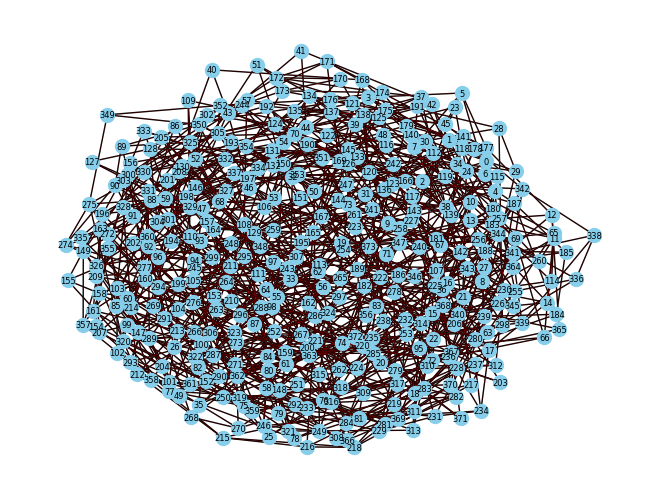

In [20]:
Graph_WS = nx.watts_strogatz_graph(size, k, p_values[1])

# Relabel the nodes
Graph_WS = nx.convert_node_labels_to_integers(Graph_WS, first_label=0)

# create a layout for the nodes
pos = nx.kamada_kawai_layout(Graph_WS)

# draw the nodes and edges
nx.draw(Graph_WS, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_color='black')
nx.draw_networkx_edges(Graph_WS, pos, edge_color='red', width=0.1)

# display the graph
plt.axis('off')
# plt.title("Network Visualization")
plt.savefig('Figures/Network_WAtts_Strogatz.png')
plt.show()

## Barabási-Albert network

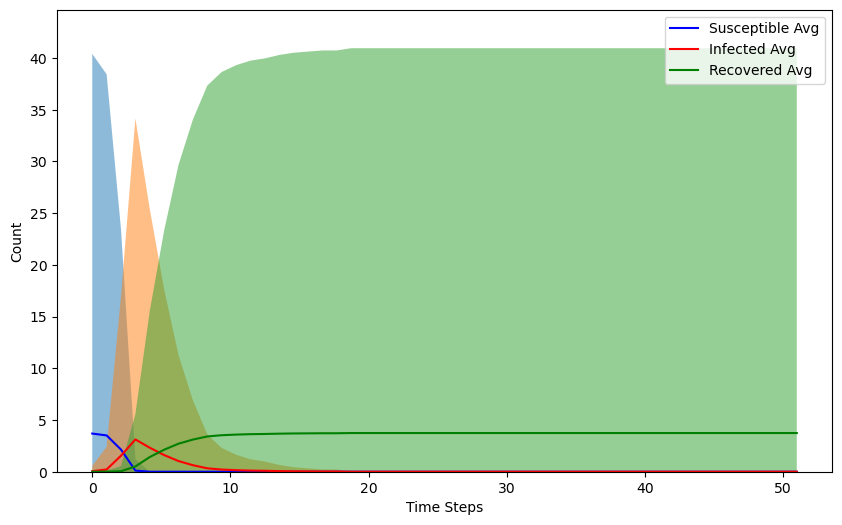

Nr_of_edges      Average_degree       \
                   mean  std           mean  std   
Nr_of_nodes                                        
374              1113.0  0.0      96.225936  0.0   

            average_clustering_coefficient             density       \
                                      mean       std      mean  std   
Nr_of_nodes                                                           
374                               0.062317  0.009791  0.015957  0.0   

            average_degree_centrality                \
                                 mean           std   
Nr_of_nodes                                           
374                          0.015957  4.931257e-19   

            average_betweenness_centrality            \
                                      mean       std   
Nr_of_nodes                                            
374                               0.005703  0.000104   

            average_closeness_centrality           diameter            \
                                    mean       std     mean       std   
Nr_of_nodes                                                             
374                             0.323498  0.004108     5.05  0.219043   

            average_shortest_path_length            
                                    mean       std  
Nr_of_nodes                                         
374                             3.121631  0.038662

In [21]:
# Parameters such that the number of edges is close to the 1265 edges of the sociopatters data set
size = 374
m = 3
runs = 100
results_BA = []
x = np.linspace(0, nr_iterations+1, nr_iterations)

# Set parameter values
beta = 1.5
gamma = 0.3
percentage_infected = 5/374
nr_iterations = 50

# Pre-allocate variables.
S_BA = np.zeros((runs, nr_iterations))
I_BA = np.zeros((runs, nr_iterations))
R_BA = np.zeros((runs, nr_iterations))

for _ in range(runs):
    Graph_BA = nx.barabasi_albert_graph(size, m)
    stats_BA = statistic_func(Graph_BA)
    results_BA.append(stats_BA)
    
    # Generate SIR model object
    SIR_model = ep.SIRModel(Graph_BA)
    
    # Run experiment
    cfg = mc.Configuration()
    cfg.add_model_parameter("percentage_infected", percentage_infected)

    # Set every node as susceptible
    for node in Graph_obj.nodes():
        SIR_model.status[node] = 0
        
    # Set model configurations
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('gamma', gamma)
    SIR_model.set_initial_status(cfg)

    for t in range(nr_iterations):
        iteration = SIR_model.iteration(node_status=True)

        # Extract values based on updated structure
        node_counts = SIR_model.build_trends([iteration])[0]['trends']['node_count']
        S_BA[run, t] = node_counts[0][-1]
        I_BA[run, t] = node_counts[1][-1]
        R_BA[run, t] = node_counts[2][-1]



df_BA = pd.DataFrame(results_BA)
        
S_BA_mean = np.mean(S_BA, axis=0)
S_BA_std = np.std(S_BA, axis=0)
I_BA_mean = np.mean(I_BA, axis=0)
I_BA_std = np.std(I_BA, axis=0)
R_BA_mean = np.mean(R_BA, axis=0)
R_BA_std = np.std(R_BA, axis=0)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S_BA_mean, label="Susceptible Avg", color='blue')
plt.fill_between(x, S_BA_mean - S_BA_std, S_BA_mean + S_BA_std, alpha=0.5)
plt.plot(x, I_BA_mean, label="Infected Avg", color='red')
plt.fill_between(x, I_BA_mean - I_BA_std, I_BA_mean + I_BA_std, alpha=0.5)
plt.plot(x, R_BA_mean, label="Recovered Avg", color='green')
plt.fill_between(x, R_BA_mean - R_BA_std, R_BA_mean + R_BA_std, alpha=0.5)
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.ylim(bottom=0)
plt.savefig(f'Figures/Barabasi_Albert_size_{size}_m_{m}.png')
plt.show()

df_BA = pd.DataFrame(results_BA)
custom_summary_BA = df_BA.groupby(df_BA.columns[0]).agg(['mean', 'std'])
display(custom_summary_BA)

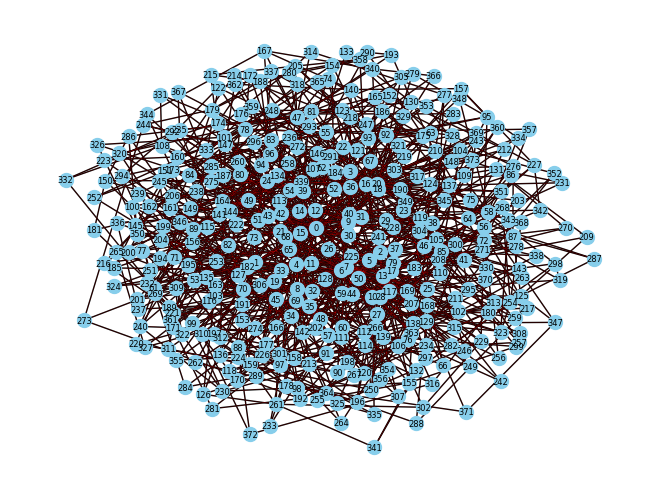

In [22]:
Graph_BA = nx.barabasi_albert_graph(size, m)

# Relabel the nodes
Graph_BA = nx.convert_node_labels_to_integers(Graph_BA, first_label=0)

# create a layout for the nodes
pos = nx.kamada_kawai_layout(Graph_BA)

# draw the nodes and edges
nx.draw(Graph_BA, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_color='black')
nx.draw_networkx_edges(Graph_BA, pos, edge_color='red', width=0.1)

# display the graph
plt.axis('off')
# plt.title("Network Visualization")
plt.savefig('Figures/Network_Barabasi_Albert.png')
plt.show()

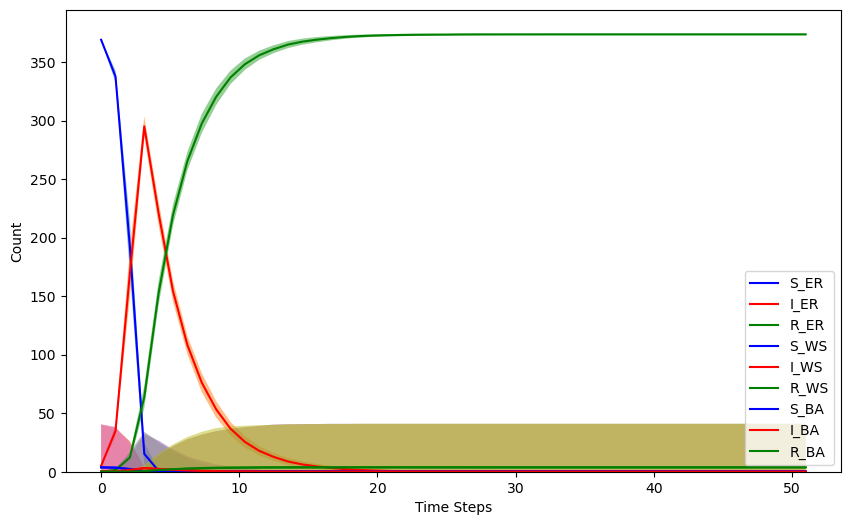

In [23]:
# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S_ER_mean, label="S_ER", color='blue')
plt.fill_between(x, S_ER_mean - S_ER_std, S_ER_mean + S_ER_std, alpha=0.5)
plt.plot(x, I_ER_mean, label="I_ER", color='red')
plt.fill_between(x, I_ER_mean - I_ER_std, I_ER_mean + I_ER_std, alpha=0.5)
plt.plot(x, R_ER_mean, label="R_ER", color='green')
plt.fill_between(x, R_ER_mean - R_ER_std, R_ER_mean + R_ER_std, alpha=0.5)
plt.plot(x, S_WS_mean, label="S_WS", color='blue')
plt.fill_between(x, S_WS_mean - S_WS_std, S_WS_mean + S_WS_std, alpha=0.5)
plt.plot(x, I_WS_mean, label="I_WS", color='red')
plt.fill_between(x, I_WS_mean - I_WS_std, I_WS_mean + I_WS_std, alpha=0.5)
plt.plot(x, R_WS_mean, label="R_WS", color='green')
plt.fill_between(x, R_WS_mean - R_WS_std, R_WS_mean + R_WS_std, alpha=0.5)
plt.plot(x, S_BA_mean, label="S_BA", color='blue')
plt.fill_between(x, S_BA_mean - S_BA_std, S_BA_mean + S_BA_std, alpha=0.5)
plt.plot(x, I_BA_mean, label="I_BA", color='red')
plt.fill_between(x, I_BA_mean - I_BA_std, I_BA_mean + I_BA_std, alpha=0.5)
plt.plot(x, R_BA_mean, label="R_BA", color='green')
plt.fill_between(x, R_BA_mean - R_BA_std, R_BA_mean + R_BA_std, alpha=0.5)
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.ylim(bottom=0)
plt.savefig('Networks_together')
plt.show()

In [24]:
# Adding an identifier column to each DataFrame
custom_summary_WS['Model'] = 'Watts-Strogatz'
custom_summary_ER['Model'] = 'Erdos-Reyni'
custom_summary_BA['Model'] = 'Barabasi-Albert'

# Concatenating the DataFrames along the row axis
combined_summary = pd.concat([custom_summary_ER, custom_summary_WS, custom_summary_BA], axis=0)

# Setting 'Model' as the index for display purposes
combined_summary.set_index('Model', inplace=True)

# Displaying the combined summary
display(combined_summary.T)

Model                                Erdos-Reyni  Watts-Strogatz  \
Nr_of_edges                    mean  1253.950000     1122.000000   
                               std     34.909804        0.000000   
Average_degree                 mean    96.602807       96.250000   
                               std      0.093342        0.000000   
average_clustering_coefficient mean     0.017357        0.066869   
                               std      0.003385        0.006616   
density                        mean     0.017978        0.016086   
                               std      0.000500        0.000000   
average_degree_centrality      mean     0.017978        0.016086   
                               std      0.000500        0.000000   
average_betweenness_centrality mean     0.006224        0.007008   
                               std      0.000114        0.000034   
average_closeness_centrality   mean     0.302146        0.277855   
                               std      0.004201        0.000967   
diameter                       mean     6.188406        6.000000   
                               std      0.393901        0.000000   
average_shortest_path_length   mean     3.314950        3.607143   
                               std      0.041606        0.012546   

Model                                Barabasi-Albert  
Nr_of_edges                    mean     1.113000e+03  
                               std      0.000000e+00  
Average_degree                 mean     9.622594e+01  
                               std      0.000000e+00  
average_clustering_coefficient mean     6.231706e-02  
                               std      9.790951e-03  
density                        mean     1.595676e-02  
                               std      0.000000e+00  
average_degree_centrality      mean     1.595676e-02  
                               std      4.931257e-19  
average_betweenness_centrality mean     5.703310e-03  
                               std      1.039292e-04  
average_closeness_centrality   mean     3.234983e-01  
                               std      4.108023e-03  
diameter                       mean     5.050000e+00  
                               std      2.190429e-01  
average_shortest_path_length   mean     3.121631e+00  
                               std      3.866166e-02

## Dynamic Vaccination Campaign

### The null strategy

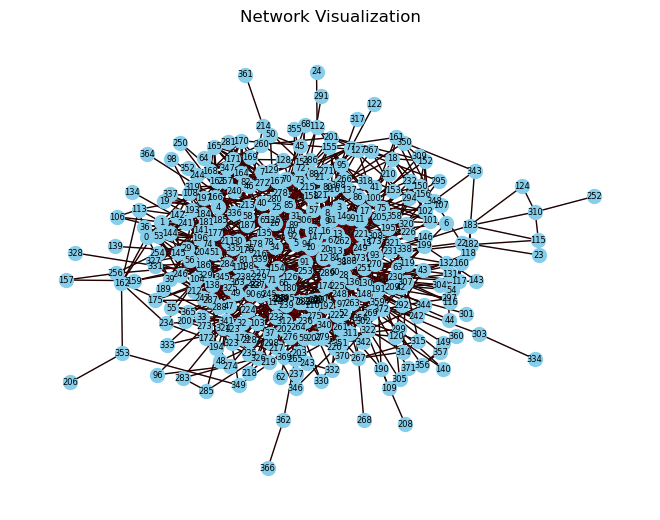

In [25]:
# Import the csv file
df = pd.read_csv('transmission_network.csv', sep=';')
df = df.rename(columns={df.columns[0]:'nodes'})

# Create graph object and add nodes to it
Graph_obj = nx.Graph()
nodes = df['nodes'].tolist()
Graph_obj.add_nodes_from(nodes)

# Add edges between nodes based on the csv-file
for _, row in df.iterrows():
    source_node = row['nodes']
    for col_name, edge_value in row.items():
        if col_name != 'nodes' and edge_value != 0:
            Graph_obj.add_edge(source_node, int(col_name))
            

# Relabel the nodes
Graph_obj = nx.convert_node_labels_to_integers(Graph_obj, first_label=0)

# create a layout for the nodes
pos = nx.kamada_kawai_layout(Graph_obj)

# draw the nodes and edges
nx.draw(Graph_obj, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_color='black')
nx.draw_networkx_edges(Graph_obj, pos, edge_color='red', width=0.1)

# display the graph
plt.axis('off')
plt.title("Network Visualization")
plt.show()

In [26]:
def simulation_run(S, I, R, vacc_ix, acc_ix, run, null_strategy, SIR_model, non_vaccinated_nodes, vaccinations_per_timestep, test_accuracy, tests_left, vaccinated_nodes):
    for t in range(nr_iterations):
        iteration = SIR_model.iteration(node_status=True)
        if not null_strategy:
            # Pre-allocate useful variables
            counter = 0
            nodes_to_vaccinate = []
            
            # Re-order the list of non_vaccinated_nodes such that the nodes with the highest degrees are vaccinated first.
            node_degrees = {node: Graph_obj.degree(node) for node in non_vaccinated_nodes}
            ranked_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)
            
            # a list of nodes_to_vaccinate will be appended with nodes that have been tested as susceptible only if there are tests left.
            # So the number of executed tests is dynamic such that the number of detected susceptibles is equal to the number of vaccinations 
            # that is allowed to perform each timestep or the number of tests we can execute is 0. 
            while len(nodes_to_vaccinate) < vaccinations_per_timestep and tests_left > 0:
                p = np.random.uniform()
                
                # We don't vaccinate false negatives (so the node is actually susceptible, but is tested as something else).
                # We do add false positives (so the node is falsely tested to be susceptible) to the vaccination lists, but don't change the state.
                # If it was already recovered, it won't change. 
                # If it was infected, the vaccination won't make the node go to recovered quicker than the infected state will. 
                if p < test_accuracy and SIR_model.status[ranked_nodes[counter]] == 0:
                    nodes_to_vaccinate.append(ranked_nodes[counter])
                elif p > test_accuracy and (SIR_model.status[ranked_nodes[counter]] == 1 or SIR_model.status[ranked_nodes[counter]] == 2):
                    nodes_to_vaccinate.append(ranked_nodes[counter])
                counter += 1
                tests_left -= 1
            
            # How to deal with having no tests left
            if len(nodes_to_vaccinate) < vaccinations_per_timestep:
                diff = vaccinations_per_timestep - len(nodes_to_vaccinate)
                for i in range(diff):
                    if counter + i < len(ranked_nodes):
                        nodes_to_vaccinate.append(ranked_nodes[counter+i])

        else: 
            nodes_to_vaccinate = np.random.choice(list(non_vaccinated_nodes), min(vaccinations_per_timestep, len(non_vaccinated_nodes)), replace=False)
            

        for node in nodes_to_vaccinate:
            if SIR_model.status[node] == 1:
                vaccinated_nodes.add(node)
                non_vaccinated_nodes.remove(node)
            else: 
                SIR_model.status[node] = 2 
                vaccinated_nodes.add(node)
                non_vaccinated_nodes.remove(node)

        # Extract values based on updated structure
        node_counts = SIR_model.build_trends([iteration])[0]['trends']['node_count']
        S[acc_ix, vacc_ix, null_strategy, run, t] = node_counts[0][-1]
        I[acc_ix, vacc_ix, null_strategy, run, t] = node_counts[1][-1]
        R[acc_ix, vacc_ix, null_strategy, run, t] = node_counts[2][-1]
        
    return S, I, R

In [27]:
test_accuracies = [0.5, 0.75, 1]
vaccinations_per_timestep_Values = [1, 3, 5, 10]
null_strategies = [0, 1]
runs = 1000
nr_iterations = 50

# Pre-allocate variables.
S = np.zeros((len(test_accuracies), len(vaccinations_per_timestep_Values), len(null_strategies), runs, nr_iterations))
I = np.zeros((len(test_accuracies), len(vaccinations_per_timestep_Values), len(null_strategies), runs, nr_iterations))
R = np.zeros((len(test_accuracies), len(vaccinations_per_timestep_Values), len(null_strategies), runs, nr_iterations))
x = np.linspace(0, nr_iterations+1, nr_iterations)


for vacc_ix, vaccinations_per_timestep in enumerate(vaccinations_per_timestep_Values):
    for acc_ix, test_accuracy in enumerate(test_accuracies):
        for null_strategy in null_strategies:
            for run in range(runs):
                # Generate SIR model object
                SIR_model = ep.SIRModel(Graph_obj)

                # Set parameter values
                beta = 0.3
                gamma = 0.2
                percentage_infected = 5/374
                nr_iterations = 50
                tests_left = 200


                vaccinated_nodes = set()
                non_vaccinated_nodes = set(Graph_obj.nodes())

                # Run experiment
                cfg = mc.Configuration()
                cfg.add_model_parameter("percentage_infected", percentage_infected) 


                # (Re)set every node as susceptible
                for node in Graph_obj.nodes():
                    SIR_model.status[node] = 0
                    
                # Set model configurations
                cfg.add_model_parameter('beta', beta)
                cfg.add_model_parameter('gamma', gamma)
                SIR_model.set_initial_status(cfg)

                S, I, R = simulation_run(S, I, R, vacc_ix, acc_ix, run, null_strategy, SIR_model, non_vaccinated_nodes, vaccinations_per_timestep, test_accuracy, tests_left, vaccinated_nodes)



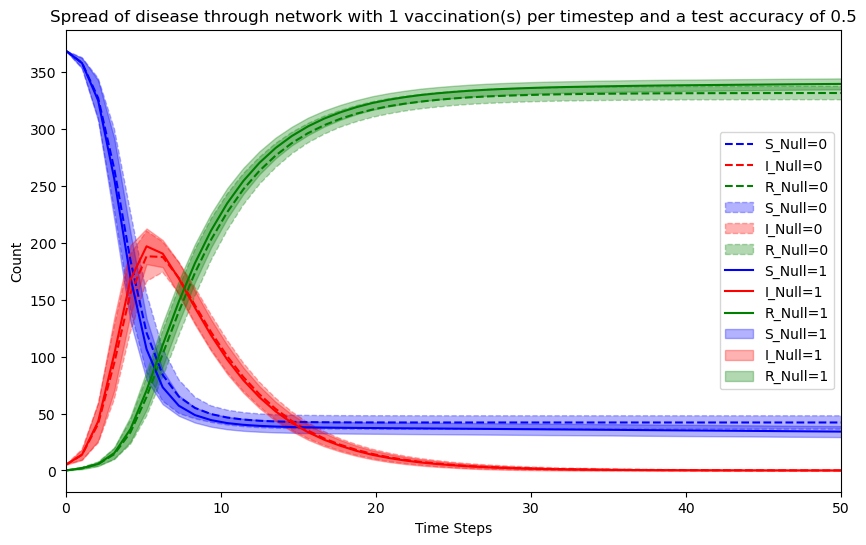

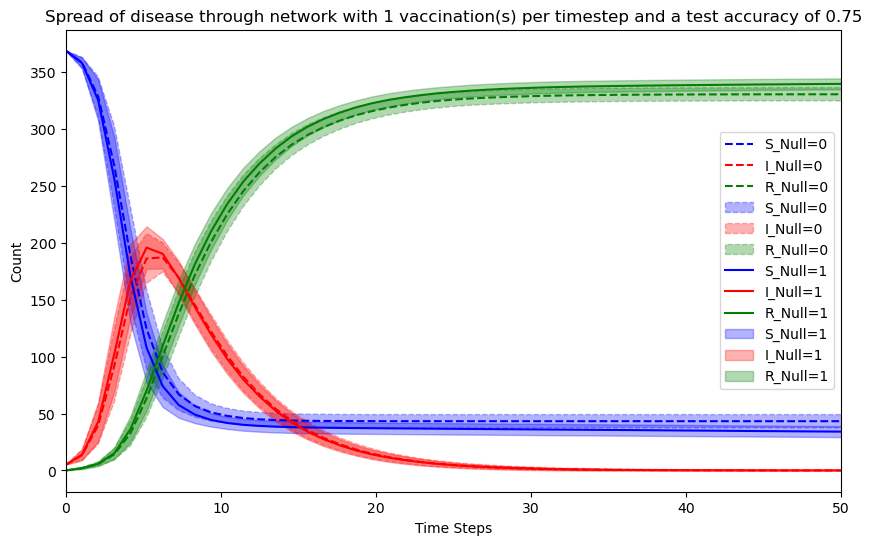

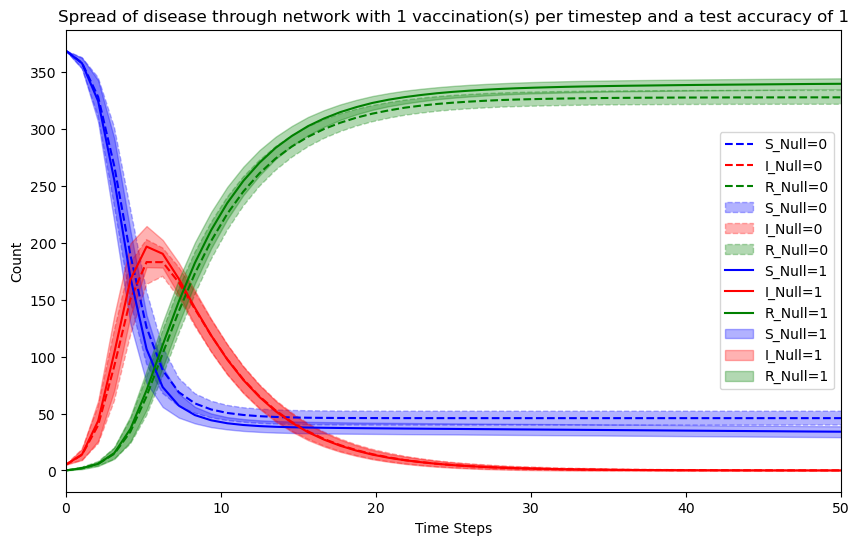

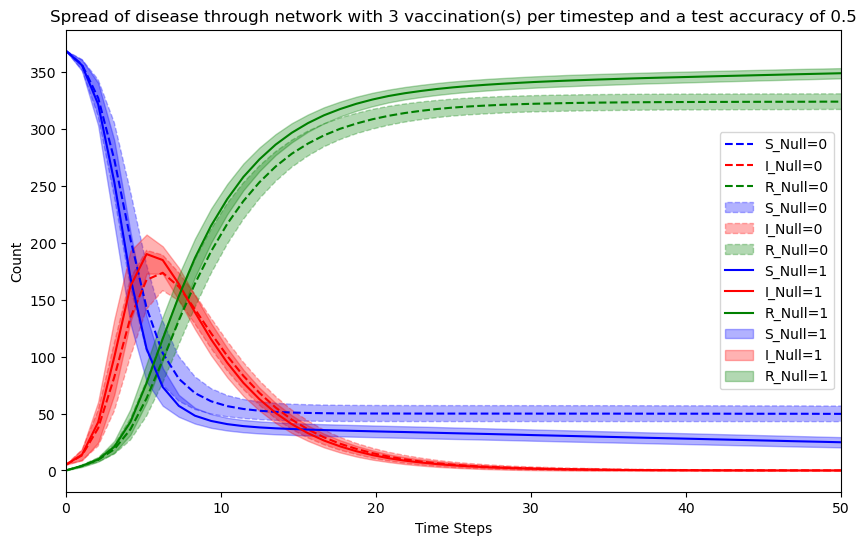

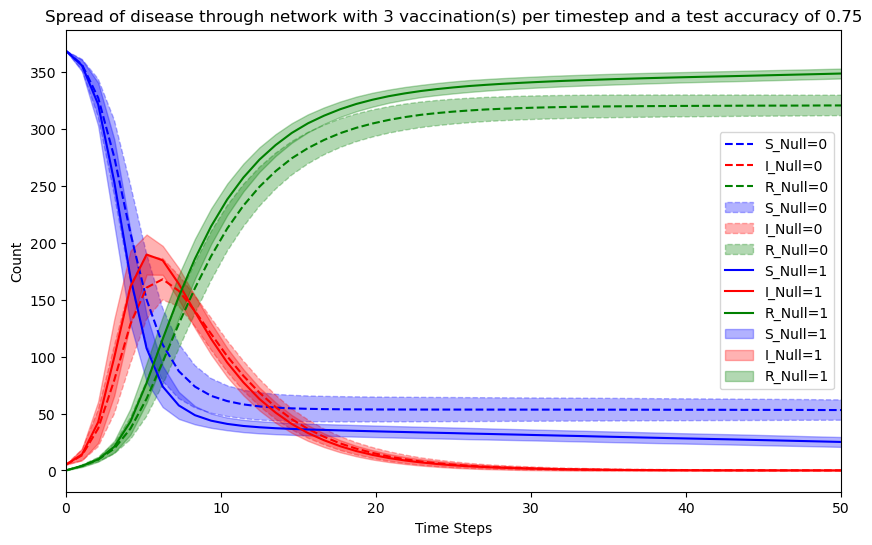

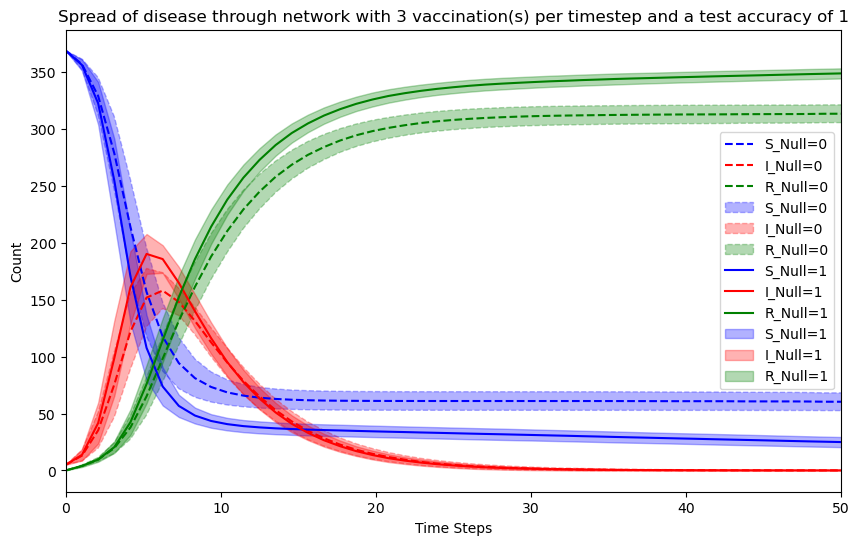

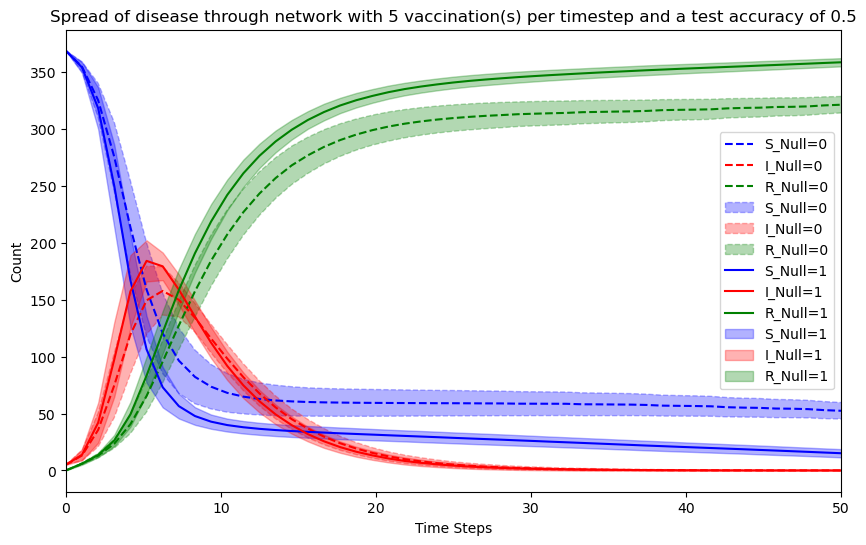

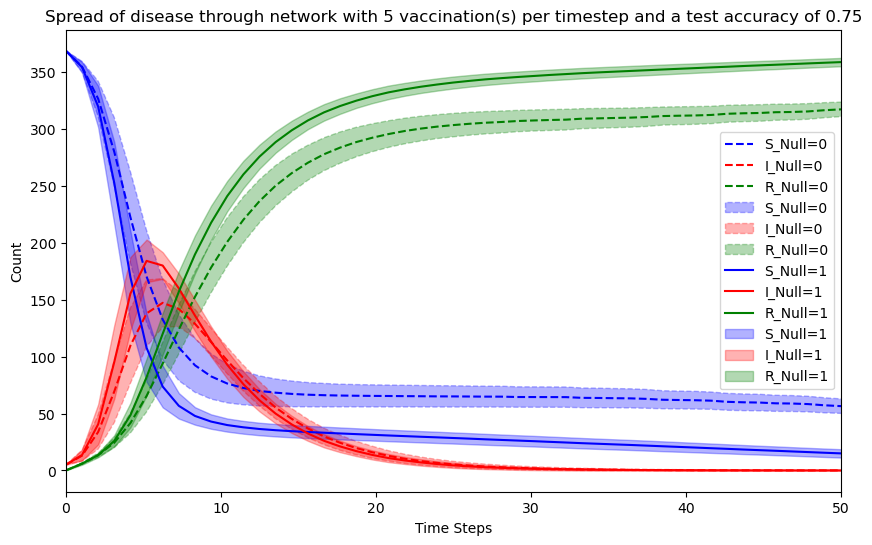

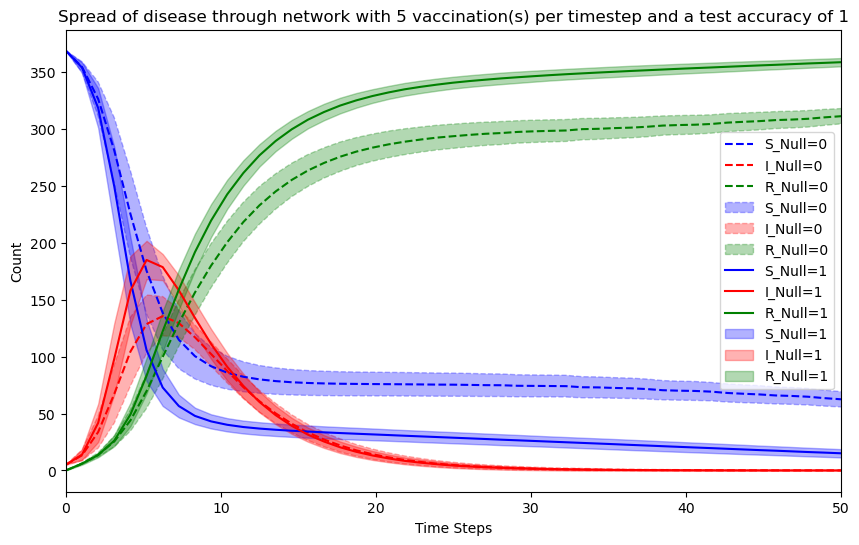

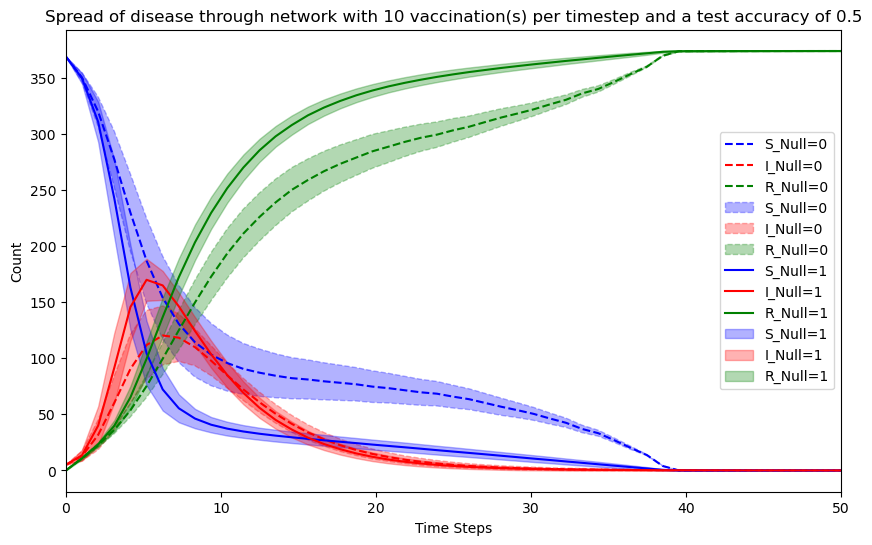

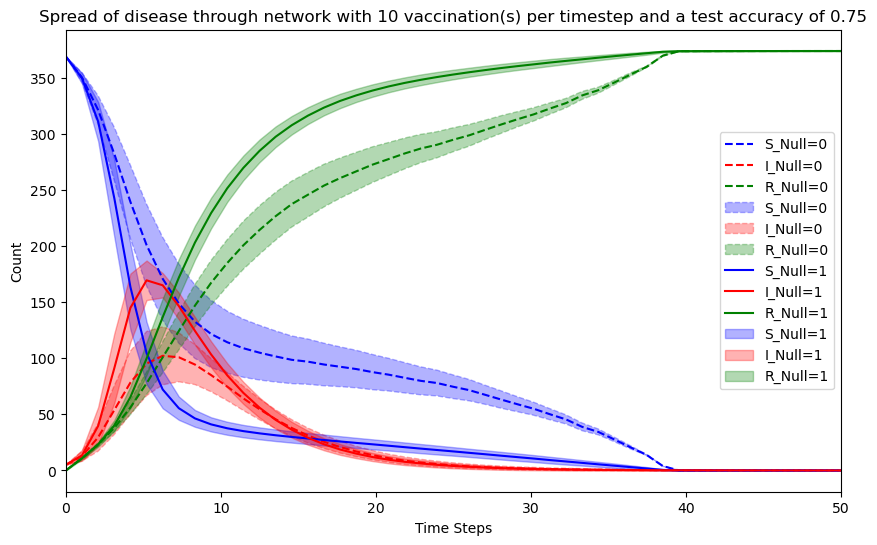

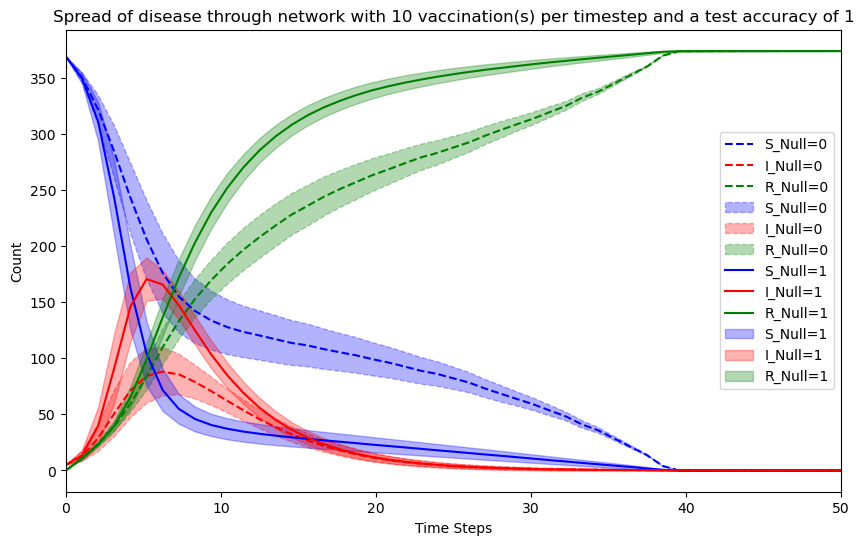

In [28]:
S_mean = np.mean(S, axis=3)
I_mean = np.mean(I, axis=3)
R_mean = np.mean(R, axis=3)
S_std = np.std(S, axis=3)
I_std = np.std(I, axis=3)
R_std = np.std(R, axis=3)


for vacc_ix, vaccinations_per_timestep in enumerate(vaccinations_per_timestep_Values):
    for acc_ix, test_accuracy in enumerate(test_accuracies):
        plt.figure(figsize=(10, 6))
        for null_strategy in null_strategies:
            # Plot of average dynamics
            if null_strategy:
                linestyle='-'
            else:
                linestyle='--'
            plt.plot(x, S_mean[acc_ix, vacc_ix, null_strategy], label=f"S_Null={null_strategy}", color='blue', linestyle=linestyle)
            plt.plot(x, I_mean[acc_ix, vacc_ix, null_strategy], label=f"I_Null={null_strategy}", color='red', linestyle=linestyle)
            plt.plot(x, R_mean[acc_ix, vacc_ix, null_strategy], label=f"R_Null={null_strategy}", color='green', linestyle=linestyle)
            plt.fill_between(x, S_mean[acc_ix, vacc_ix, null_strategy]+S_std[acc_ix, vacc_ix, null_strategy], S_mean[acc_ix, vacc_ix, null_strategy]-S_std[acc_ix, vacc_ix, null_strategy], label=f"S_Null={null_strategy}", color='blue', linestyle=linestyle, alpha=0.3)
            plt.fill_between(x, I_mean[acc_ix, vacc_ix, null_strategy]+I_std[acc_ix, vacc_ix, null_strategy], I_mean[acc_ix, vacc_ix, null_strategy]-I_std[acc_ix, vacc_ix, null_strategy], label=f"I_Null={null_strategy}", color='red', linestyle=linestyle, alpha=0.3)
            plt.fill_between(x, R_mean[acc_ix, vacc_ix, null_strategy]+R_std[acc_ix, vacc_ix, null_strategy], R_mean[acc_ix, vacc_ix, null_strategy]-R_std[acc_ix, vacc_ix, null_strategy], label=f"R_Null={null_strategy}", color='green', linestyle=linestyle, alpha=0.3)
        plt.title(f'Spread of disease through network with {vaccinations_per_timestep}'
                f' vaccination(s) per timestep and a test accuracy of {test_accuracy}')
        plt.xlabel("Time Steps")
        plt.ylabel("Count")
        plt.legend()
        plt.xlim((0,50))
        plt.savefig(f'Figures/Spatial_vacc_with_vaccpertime_{vaccinations_per_timestep}_and_testaccuracy_{test_accuracy}.png')
        plt.show()

In [29]:
I_peak = np.max(I, axis=4)

for vacc_ix, vaccinations_per_timestep in enumerate(vaccinations_per_timestep_Values):
    for acc_ix, test_accuracy in enumerate(test_accuracies):
        print('--------------------------------------------------')
        print(f'With #vaccinations per timestep = {vaccinations_per_timestep} and test_accuracy = {test_accuracy}')        
        stat0, p_val0 = stats.normaltest(I_peak[acc_ix, vacc_ix, 0])
        stat1, p_val1 = stats.normaltest(I_peak[acc_ix, vacc_ix, 1])
        if p_val0 > 0.05 and p_val1 > 0.05:
            stat2 = stats.ttest_rel(I_peak[acc_ix, vacc_ix, 0], I_peak[acc_ix, vacc_ix, 1])
            # Knowing what the results are by running it without the elaborate reporting of the results, 
            # we didn't type out the else statement 
            if stat2.pvalue < 0.05:
                print(f'The null strategy shows a peak of infected people (M={np.mean(I_peak[acc_ix, vacc_ix, 1])}, SE={stats.sem(I_peak[acc_ix, vacc_ix, 0])})'
                      f' that is larger than the proposed strategy (M={np.mean(I_peak[acc_ix, vacc_ix, 0])}, SE={stats.sem(I_peak[acc_ix, vacc_ix, 1])})'
                      f't({stat2.df}) = {stat2.statistic}, p < 0.05')
                effect_size = np.sqrt((stat2.statistic**2)/((stat2.statistic**2)+stat2.df))
                if effect_size > 0.5:
                    print(f'This is a large effect: r={effect_size}')
                elif effect_size > 0.3 and effect_size < 0.5:
                    print(f'This is a medium effect: r={effect_size}')
                elif effect_size > 0.1 and effect_size < 0.3:
                    print(f'This is a small effect: r={effect_size}')
            else:
                print('not significant')
        else:
            stat2 = stats.wilcoxon(I_peak[acc_ix, vacc_ix, 0], I_peak[acc_ix, vacc_ix, 1])
            # Knowing what the results are by running it without the elaborate reporting of the results, 
            # we didn't type out the else statement 
            if stat2.pvalue < 0.05:
                print(f'The null strategy shows a peak of infected people (Median={int(np.median(I_peak[acc_ix, vacc_ix, 1]))})'
                      f' that is larger than the proposed strategy (Median={int(np.median(I_peak[acc_ix, vacc_ix, 0]))})'
                      f'Z = {stat2.statistic}, p < 0.05')
                effect_size = stat2.statistic/(np.sqrt(runs))
                if effect_size > 0.5:
                    print(f'This is a large effect: r={effect_size}')
                elif effect_size > 0.3 and effect_size < 0.5:
                    print(f'This is a medium effect: r={effect_size}')
                elif effect_size > 0.1 and effect_size < 0.3:
                    print(f'This is a small effect: r={effect_size}')
            else:
                print('not significant')


--------------------------------------------------
With #vaccinations per timestep = 1 and test_accuracy = 0.5
The null strategy shows a peak of infected people (M=201.871, SE=0.3306769817605487) that is larger than the proposed strategy (M=196.509, SE=0.30858318583905797)t(999) = -11.868960997459746, p < 0.05
This is a medium effect: r=0.3515479866712362
--------------------------------------------------
With #vaccinations per timestep = 1 and test_accuracy = 0.75
The null strategy shows a peak of infected people (M=201.649, SE=0.3381295248504271) that is larger than the proposed strategy (M=195.266, SE=0.3097834158969211)t(999) = -13.946598746627595, p < 0.05
This is a medium effect: r=0.4036971734922497
--------------------------------------------------
With #vaccinations per timestep = 1 and test_accuracy = 1
The null strategy shows a peak of infected people (M=202.162, SE=0.3298223124013258) that is larger than the proposed strategy (M=191.295, SE=0.310396685069448)t(999) = -23.73